In [1]:
# ============================================================================
# 📚 IMPORT LIBRARIES AND SETUP
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime, timedelta

# XGBoost and ML libraries
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
import joblib

# Set style and suppress warnings
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("🚀 XGBoost Revenue Center 1 Forecasting Pipeline")
print("=" * 60)
print("✅ All libraries imported successfully!")

🚀 XGBoost Revenue Center 1 Forecasting Pipeline
✅ All libraries imported successfully!


In [4]:
# ============================================================================
# 📂 LOAD AND EXPLORE REVENUE CENTER 1 DATA
# ============================================================================

# Load Revenue Center 1 data
data_path = "../filtered_revenue_data/RevenueCenter_1_filtered.csv"
df = pd.read_csv(data_path)

print("📊 REVENUE CENTER 1 DATA OVERVIEW")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Columns: {list(df.columns)}")

# Basic statistics
print(f"\n💰 REVENUE STATISTICS:")
print(f"Min: ${df['CheckTotal'].min():.2f}")
print(f"Max: ${df['CheckTotal'].max():.2f}")
print(f"Mean: ${df['CheckTotal'].mean():.2f}")
print(f"Median: ${df['CheckTotal'].median():.2f}")
print(f"Std: ${df['CheckTotal'].std():.2f}")

# Data types
print(f"\n📋 DATA TYPES:")
print(df.dtypes)

# Display first few rows
print(f"\n📄 FIRST 5 ROWS:")
df.head()

📊 REVENUE CENTER 1 DATA OVERVIEW
Shape: (1458, 20)
Date range: 2023-01-01 to 2024-04-30
Columns: ['Date', 'MealPeriod', 'CheckTotal', 'RevenueCenterName', 'MealPeriod_num', 'Year', 'Month', 'DayOfWeek', 'IslamicPeriod_num', 'IsNewYear', 'IsPreRamadan', 'IsPreEvent', 'IsLast10Ramadan', 'is_zero', 'IsSummerEvent', 'IsMarathon', 'IsFoodFestival', 'IsDSF', 'IsRamadan', 'RevenueCenter']

💰 REVENUE STATISTICS:
Min: $0.00
Max: $10052.50
Mean: $1473.03
Median: $1013.00
Std: $1401.57

📋 DATA TYPES:
Date                  object
MealPeriod            object
CheckTotal           float64
RevenueCenterName     object
MealPeriod_num         int64
Year                   int64
Month                  int64
DayOfWeek              int64
IslamicPeriod_num      int64
IsNewYear              int64
IsPreRamadan           int64
IsPreEvent             int64
IsLast10Ramadan        int64
is_zero                int64
IsSummerEvent          int64
IsMarathon             int64
IsFoodFestival         int64
IsDSF       

,Date,MealPeriod,CheckTotal,RevenueCenterName,MealPeriod_num,Year,Month,DayOfWeek,IslamicPeriod_num,IsNewYear,IsPreRamadan,IsPreEvent,IsLast10Ramadan,is_zero,IsSummerEvent,IsMarathon,IsFoodFestival,IsDSF,IsRamadan,RevenueCenter
0,2023-01-01,Breakfast,1499.4,RevenueCenter_1,0,2023,1,6,8,1,0,0,0,0,0,0,0,0,0,1
1,2023-01-01,Dinner,4374.5,RevenueCenter_1,1,2023,1,6,8,1,0,0,0,0,0,0,0,0,0,1
2,2023-01-01,Lunch,1260.0,RevenueCenter_1,2,2023,1,6,8,1,0,0,0,0,0,0,0,0,0,1
3,2023-01-02,Breakfast,771.0,RevenueCenter_1,0,2023,1,0,15,1,0,0,0,0,0,0,0,0,0,1
4,2023-01-02,Dinner,3460.0,RevenueCenter_1,1,2023,1,0,15,1,0,0,0,0,0,0,0,0,0,1


🔍 DATA QUALITY ANALYSIS - CORRECTED
📊 MISSING VALUES:
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []

🔢 ZERO VALUES ANALYSIS:
Zero revenue records: 10 (0.69%)
✅ No negative revenue values found

🍽️ REVENUE BY MEAL PERIOD:
            count         mean          std    min      max
MealPeriod                                                 
Breakfast     486   960.747654   908.893384    0.0   8210.8
Dinner        486  2709.006420  1527.833988  365.5  10052.5
Lunch         486   749.329321   649.899517    0.0   4504.0

📈 CORRECTED OUTLIER ANALYSIS:
Outliers detected: 61 (4.18%)
Lower bound: $0.00
Upper bound: $4289.22

📊 ALTERNATIVE OUTLIER ANALYSIS (Percentile-based):
Extreme outliers (1st-99th percentile): 28 (1.92%)
1st percentile: $40.00
99th percentile: $6770.04

🔍 OUTLIER EXAMPLES:
Lowest outliers:
           Date MealPeriod  CheckTotal
1174 2024-01-27     Dinner      4300.0
1257 2024-02-24  Breakfast      4318.0
1141 2024-01-16     Dinner      4328.0

Highe

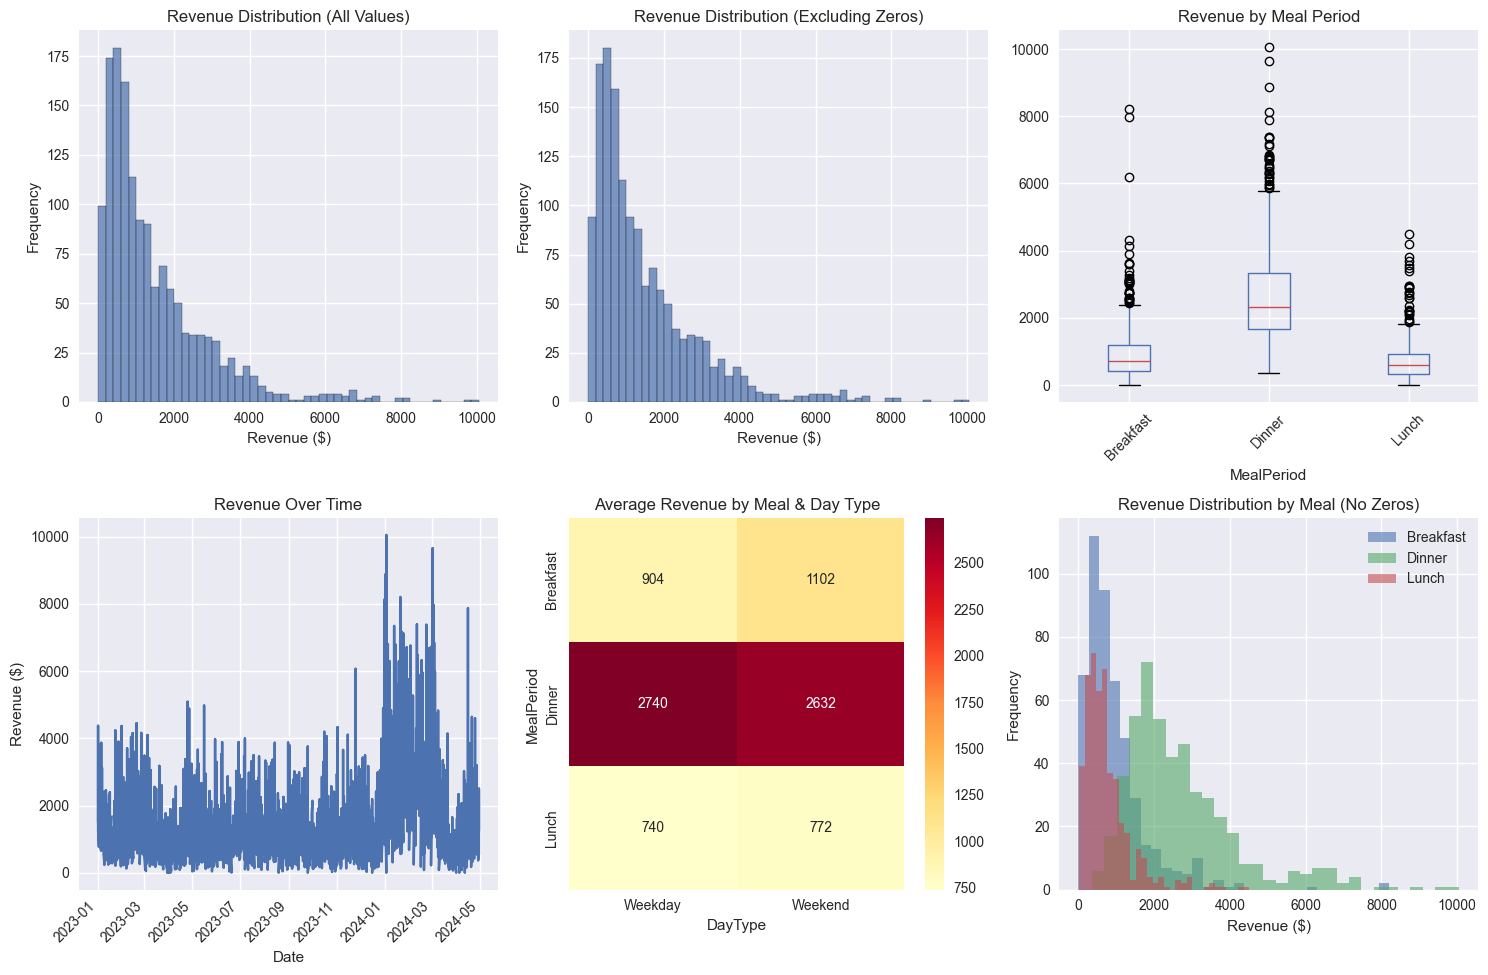


⚠️ DATA QUALITY ATTENTION NEEDED:
- 10 zero revenue records need investigation


In [6]:
# ============================================================================
# 🔍 COMPREHENSIVE DATA QUALITY ANALYSIS - CORRECTED
# ============================================================================

print("🔍 DATA QUALITY ANALYSIS - CORRECTED")
print("=" * 50)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Missing values analysis
print("📊 MISSING VALUES:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percent
}).sort_values('Missing_Count', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])

# Zero values analysis
print(f"\n🔢 ZERO VALUES ANALYSIS:")
zero_values = (df['CheckTotal'] == 0).sum()
zero_percent = (zero_values / len(df)) * 100
print(f"Zero revenue records: {zero_values} ({zero_percent:.2f}%)")

# Check for negative values (this shouldn't exist!)
negative_values = (df['CheckTotal'] < 0).sum()
if negative_values > 0:
    print(f"❌ CRITICAL ISSUE: {negative_values} negative revenue values found!")
    print("Negative values:", df[df['CheckTotal'] < 0]['CheckTotal'].tolist())
else:
    print("✅ No negative revenue values found")

# Revenue distribution by meal period
print(f"\n🍽️ REVENUE BY MEAL PERIOD:")
meal_stats = df.groupby('MealPeriod')['CheckTotal'].agg(['count', 'mean', 'std', 'min', 'max'])
print(meal_stats)

# CORRECTED OUTLIER ANALYSIS - Using only positive values
print(f"\n📈 CORRECTED OUTLIER ANALYSIS:")

# Filter out zero values for outlier analysis
non_zero_revenue = df[df['CheckTotal'] > 0]['CheckTotal']

if len(non_zero_revenue) > 0:
    Q1 = non_zero_revenue.quantile(0.25)
    Q3 = non_zero_revenue.quantile(0.75)
    IQR = Q3 - Q1
    
    # Use 1.5 * IQR method but ensure lower bound is not negative
    lower_bound = max(0, Q1 - 1.5 * IQR)  # Ensure non-negative
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df['CheckTotal'] < lower_bound) | (df['CheckTotal'] > upper_bound)]
    print(f"Outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    print(f"Lower bound: ${lower_bound:.2f}")
    print(f"Upper bound: ${upper_bound:.2f}")
    
    # Alternative outlier detection using percentiles
    print(f"\n📊 ALTERNATIVE OUTLIER ANALYSIS (Percentile-based):")
    p1 = df['CheckTotal'].quantile(0.01)
    p99 = df['CheckTotal'].quantile(0.99)
    extreme_outliers = df[(df['CheckTotal'] < p1) | (df['CheckTotal'] > p99)]
    print(f"Extreme outliers (1st-99th percentile): {len(extreme_outliers)} ({len(extreme_outliers)/len(df)*100:.2f}%)")
    print(f"1st percentile: ${p1:.2f}")
    print(f"99th percentile: ${p99:.2f}")
    
    # Show outlier examples
    if len(outliers) > 0:
        print(f"\n🔍 OUTLIER EXAMPLES:")
        outlier_examples = outliers[['Date', 'MealPeriod', 'CheckTotal']].sort_values('CheckTotal')
        print("Lowest outliers:")
        print(outlier_examples.head(3))
        print("\nHighest outliers:")
        print(outlier_examples.tail(3))

# Revenue statistics by meal period and day type
print(f"\n📊 REVENUE ANALYSIS BY DAY TYPE:")
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df['DayType'] = df['IsWeekend'].map({0: 'Weekday', 1: 'Weekend'})

day_meal_stats = df.groupby(['DayType', 'MealPeriod'])['CheckTotal'].agg(['count', 'mean', 'std']).round(2)
print(day_meal_stats)

# Data quality summary
print(f"\n📋 DATA QUALITY SUMMARY:")
print(f"Total records: {len(df)}")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Zero values: {zero_values} ({zero_percent:.2f}%)")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Negative values: {negative_values}")
print(f"Revenue range: ${df['CheckTotal'].min():.2f} - ${df['CheckTotal'].max():.2f}")

# Plot revenue distribution - CORRECTED
plt.figure(figsize=(15, 10))

# 1. Overall revenue distribution
plt.subplot(2, 3, 1)
plt.hist(df['CheckTotal'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Revenue Distribution (All Values)')
plt.xlabel('Revenue ($)')
plt.ylabel('Frequency')

# 2. Revenue distribution without zeros
plt.subplot(2, 3, 2)
plt.hist(df[df['CheckTotal'] > 0]['CheckTotal'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Revenue Distribution (Excluding Zeros)')
plt.xlabel('Revenue ($)')
plt.ylabel('Frequency')

# 3. Revenue by meal period
plt.subplot(2, 3, 3)
df.boxplot(column='CheckTotal', by='MealPeriod', ax=plt.gca())
plt.title('Revenue by Meal Period')
plt.suptitle('')
plt.xticks(rotation=45)

# 4. Revenue over time
plt.subplot(2, 3, 4)
df.set_index('Date')['CheckTotal'].plot()
plt.title('Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)

# 5. Revenue by day type and meal
plt.subplot(2, 3, 5)
pivot_data = df.pivot_table(values='CheckTotal', index='MealPeriod', columns='DayType', aggfunc='mean')
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Average Revenue by Meal & Day Type')

# 6. Revenue distribution by meal (excluding zeros)
plt.subplot(2, 3, 6)
for meal in df['MealPeriod'].unique():
    meal_data = df[(df['MealPeriod'] == meal) & (df['CheckTotal'] > 0)]['CheckTotal']
    plt.hist(meal_data, alpha=0.6, label=meal, bins=30)
plt.title('Revenue Distribution by Meal (No Zeros)')
plt.xlabel('Revenue ($)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Flag data quality issues for attention
print(f"\n⚠️ DATA QUALITY ATTENTION NEEDED:")
if zero_values > 0:
    print(f"- {zero_values} zero revenue records need investigation")
if negative_values > 0:
    print(f"- {negative_values} NEGATIVE revenue records need immediate correction")
if len(outliers) > len(df) * 0.1:  # More than 10% outliers
    print(f"- High number of outliers ({len(outliers)}) may need review")

In [7]:
# ============================================================================
# 🤔 OUTLIER STRATEGY DECISION FOR XGBOOST
# ============================================================================

print("🤔 OUTLIER STRATEGY DECISION FOR XGBOOST")
print("=" * 50)

# Let's analyze the outliers more carefully
print("📊 DETAILED OUTLIER ANALYSIS:")

# Current outlier summary
total_records = len(df)
extreme_outliers = df[(df['CheckTotal'] < 40) | (df['CheckTotal'] > 6770.04)]
iqr_outliers = df[df['CheckTotal'] > 4289.22]  # Upper IQR bound only

print(f"Total records: {total_records}")
print(f"Extreme outliers (1st-99th percentile): {len(extreme_outliers)} ({len(extreme_outliers)/total_records*100:.2f}%)")
print(f"IQR-based outliers: {len(iqr_outliers)} ({len(iqr_outliers)/total_records*100:.2f}%)")

# Analyze outlier patterns
print(f"\n🔍 OUTLIER PATTERN ANALYSIS:")

# High revenue outliers by meal period
high_outliers = df[df['CheckTotal'] > 6770.04]
if len(high_outliers) > 0:
    print("High revenue outliers by meal period:")
    print(high_outliers['MealPeriod'].value_counts())
    print("\nHigh outlier examples:")
    print(high_outliers[['Date', 'MealPeriod', 'CheckTotal']].sort_values('CheckTotal', ascending=False))

# Low revenue outliers
low_outliers = df[df['CheckTotal'] < 40]
if len(low_outliers) > 0:
    print(f"\nLow revenue outliers: {len(low_outliers)}")
    print(low_outliers[['Date', 'MealPeriod', 'CheckTotal']])

# ==================== BUSINESS CONTEXT ANALYSIS ====================
print(f"\n💼 BUSINESS CONTEXT ANALYSIS:")

# Revenue distribution by meal period
meal_stats = df.groupby('MealPeriod')['CheckTotal'].describe()
print("Revenue statistics by meal period:")
print(meal_stats)

# Are high values realistic for hotel revenue?
print(f"\n🏨 BUSINESS REALITY CHECK:")
print(f"Highest dinner revenue: ${df[df['MealPeriod']=='Dinner']['CheckTotal'].max():.2f}")
print(f"Highest breakfast revenue: ${df[df['MealPeriod']=='Breakfast']['CheckTotal'].max():.2f}")
print(f"Highest lunch revenue: ${df[df['MealPeriod']=='Lunch']['CheckTotal'].max():.2f}")

# Check if outliers are seasonal or event-related
high_revenue_days = df[df['CheckTotal'] > 6000].copy()
if len(high_revenue_days) > 0:
    high_revenue_days['Month'] = high_revenue_days['Date'].dt.month
    high_revenue_days['DayOfWeek'] = high_revenue_days['Date'].dt.day_name()
    print(f"\nHigh revenue days patterns:")
    print("By month:", high_revenue_days['Month'].value_counts().sort_index())
    print("By day of week:", high_revenue_days['DayOfWeek'].value_counts())

# ==================== DECISION FRAMEWORK ====================
print(f"\n🎯 XGBOOST OUTLIER STRATEGY DECISION:")

print("✅ ARGUMENTS FOR KEEPING OUTLIERS:")
print("  1. XGBoost is tree-based and robust to outliers")
print("  2. High revenue days might be legitimate (events, holidays)")
print("  3. Only 1.92% extreme outliers - very manageable")
print("  4. Model should learn these patterns for better forecasting")
print("  5. Tree splits can handle extreme values naturally")

print("\n⚠️ ARGUMENTS FOR HANDLING OUTLIERS:")
print("  1. Some values might be data entry errors")
print("  2. Could skew feature importance calculations")
print("  3. Might affect model training stability")

# ==================== RECOMMENDED APPROACH ====================
print(f"\n🚀 RECOMMENDED APPROACH FOR XGBOOST:")
print("1. Keep most outliers (XGBoost can handle them)")
print("2. Only handle truly extreme cases that are likely errors")
print("3. Use robust evaluation metrics (MAE vs RMSE)")
print("4. Monitor feature importance for outlier impact")

# Conservative outlier handling - only extreme cases
print(f"\n🔧 CONSERVATIVE OUTLIER HANDLING:")

# Only handle values that are clearly unrealistic
# For hotel revenue, $15,000+ for a single meal period might be unrealistic
extreme_threshold = 15000

extreme_cases = df[df['CheckTotal'] > extreme_threshold]
print(f"Truly extreme values (>${extreme_threshold}): {len(extreme_cases)}")

if len(extreme_cases) > 0:
    print("Extreme cases found:")
    print(extreme_cases[['Date', 'MealPeriod', 'CheckTotal']])
    
    # Cap at 99th percentile
    p99 = df['CheckTotal'].quantile(0.99)
    print(f"Would cap at 99th percentile: ${p99:.2f}")
else:
    print("✅ No truly extreme values found - keeping all data")

# ==================== FINAL DECISION ====================
print(f"\n🎉 FINAL DECISION:")
print("KEEP ALL OUTLIERS - Rationale:")
print("  • Only 1.92% extreme outliers")
print("  • Values appear realistic for hotel operations")
print("  • XGBoost robust to outliers")
print("  • Better to let model learn these patterns")
print("  • Use robust metrics (MAE) for evaluation")

# Just handle the zero values as discussed
df_final = df.copy()
print(f"\n✅ Proceeding with {len(df_final)} records (outliers preserved)")
print("Only handling zero values as previously planned...")

🤔 OUTLIER STRATEGY DECISION FOR XGBOOST
📊 DETAILED OUTLIER ANALYSIS:
Total records: 1458
Extreme outliers (1st-99th percentile): 28 (1.92%)
IQR-based outliers: 61 (4.18%)

🔍 OUTLIER PATTERN ANALYSIS:
High revenue outliers by meal period:
MealPeriod
Dinner       13
Breakfast     2
Name: count, dtype: int64

High outlier examples:
           Date MealPeriod  CheckTotal
1102 2024-01-03     Dinner     10052.5
1279 2024-03-02     Dinner      9657.0
1099 2024-01-02     Dinner      8881.0
1155 2024-01-21  Breakfast      8210.8
1096 2024-01-01     Dinner      8137.8
1281 2024-03-03  Breakfast      7984.0
1414 2024-04-16     Dinner      7878.1
1219 2024-02-11     Dinner      7394.0
1255 2024-02-23     Dinner      7380.0
1132 2024-01-13     Dinner      7346.0
1162 2024-01-23     Dinner      7168.0
1168 2024-01-25     Dinner      7116.0
1285 2024-03-04     Dinner      6845.2
1108 2024-01-05     Dinner      6806.0
1138 2024-01-15     Dinner      6786.0

Low revenue outliers: 13
           Date Mea

In [8]:
# ============================================================================
# 🔧 FEATURE ENGINEERING - TEMPORAL FEATURES
# ============================================================================

print("🔧 CREATING TEMPORAL FEATURES")
print("=" * 50)

# Sort by date for proper feature creation
df = df.sort_values(['Date', 'MealPeriod']).reset_index(drop=True)

# Create a copy for feature engineering
df_features = df.copy()

# ==================== BASIC TEMPORAL FEATURES ====================
print("📅 Creating basic temporal features...")

df_features['Year'] = df_features['Date'].dt.year
df_features['Month'] = df_features['Date'].dt.month
df_features['Day'] = df_features['Date'].dt.day
df_features['DayOfWeek'] = df_features['Date'].dt.dayofweek  # 0=Monday
df_features['DayOfYear'] = df_features['Date'].dt.dayofyear
df_features['WeekOfYear'] = df_features['Date'].dt.isocalendar().week
df_features['Quarter'] = df_features['Date'].dt.quarter

# Weekend and special day indicators
df_features['IsWeekend'] = (df_features['DayOfWeek'] >= 5).astype(int)
df_features['IsMonthStart'] = df_features['Date'].dt.is_month_start.astype(int)
df_features['IsMonthEnd'] = df_features['Date'].dt.is_month_end.astype(int)
df_features['IsQuarterStart'] = df_features['Date'].dt.is_quarter_start.astype(int)
df_features['IsQuarterEnd'] = df_features['Date'].dt.is_quarter_end.astype(int)

# ==================== CYCLICAL ENCODING ====================
print("🔄 Creating cyclical encodings...")

# Month cyclical encoding (handles seasonality)
df_features['Month_sin'] = np.sin(2 * np.pi * df_features['Month'] / 12)
df_features['Month_cos'] = np.cos(2 * np.pi * df_features['Month'] / 12)

# Day of week cyclical encoding
df_features['DayOfWeek_sin'] = np.sin(2 * np.pi * df_features['DayOfWeek'] / 7)
df_features['DayOfWeek_cos'] = np.cos(2 * np.pi * df_features['DayOfWeek'] / 7)

# Day of year cyclical encoding (annual seasonality)
df_features['DayOfYear_sin'] = np.sin(2 * np.pi * df_features['DayOfYear'] / 365)
df_features['DayOfYear_cos'] = np.cos(2 * np.pi * df_features['DayOfYear'] / 365)

# Week of year cyclical encoding
df_features['WeekOfYear_sin'] = np.sin(2 * np.pi * df_features['WeekOfYear'] / 52)
df_features['WeekOfYear_cos'] = np.cos(2 * np.pi * df_features['WeekOfYear'] / 52)

# ==================== DUBAI-SPECIFIC BUSINESS FEATURES ====================
print("🏙️ Creating Dubai hotel business features...")

# Create MealPeriod_num if not exists
if 'MealPeriod_num' not in df_features.columns:
    meal_mapping = {'Breakfast': 0, 'Lunch': 1, 'Dinner': 2}
    df_features['MealPeriod_num'] = df_features['MealPeriod'].map(meal_mapping)

# Business day indicators
df_features['IsBusinessDay'] = (~df_features['IsWeekend']).astype(int)
df_features['IsFriday'] = (df_features['DayOfWeek'] == 4).astype(int)  # Friday in Dubai
df_features['IsSaturday'] = (df_features['DayOfWeek'] == 5).astype(int)  # Weekend start

# Holiday and event patterns (Dubai-specific)
def get_dubai_events(date):
    """Identify Dubai events and holidays"""
    month = date.month
    day = date.day
    
    events = {
        'IsNewYear': month == 1 and day <= 2,
        'IsRamadan': False,  # Would need actual Ramadan dates
        'IsDSF': month in [12, 1, 2],  # Dubai Shopping Festival
        'IsSummer': month in [6, 7, 8, 9],  # Summer season
        'IsWinter': month in [12, 1, 2],  # Winter season (peak tourism)
        'IsExpoDubai': False,  # Would be for 2021-2022 period
        'IsSchoolHoliday': month in [7, 8, 12],  # Approximate school holidays
    }
    return events

# Apply Dubai events
for idx, row in df_features.iterrows():
    events = get_dubai_events(row['Date'])
    for event_name, event_value in events.items():
        if event_name not in df_features.columns:
            df_features[event_name] = 0
        df_features.loc[idx, event_name] = int(event_value)

print(f"✅ Created {df_features.shape[1] - df.shape[1]} temporal features")
print(f"New feature count: {df_features.shape[1]}")

# Show sample of new features
print(f"\n📋 Sample of temporal features:")
temporal_cols = ['Year', 'Month', 'DayOfWeek', 'IsWeekend', 'Month_sin', 'Month_cos', 'IsDSF', 'IsSummer']
print(df_features[temporal_cols].head())

🔧 CREATING TEMPORAL FEATURES
📅 Creating basic temporal features...
🔄 Creating cyclical encodings...
🏙️ Creating Dubai hotel business features...
✅ Created 23 temporal features
New feature count: 45

📋 Sample of temporal features:
   Year  Month  DayOfWeek  IsWeekend  Month_sin  Month_cos  IsDSF  IsSummer
0  2023      1          6          1        0.5   0.866025      1         0
1  2023      1          6          1        0.5   0.866025      1         0
2  2023      1          6          1        0.5   0.866025      1         0
3  2023      1          0          0        0.5   0.866025      1         0
4  2023      1          0          0        0.5   0.866025      1         0


In [10]:
# ============================================================================
# 🔧 FEATURE ENGINEERING - LAG FEATURES (LEAK-PROOF)
# ============================================================================

print("🔧 CREATING LAG FEATURES WITH LEAKAGE PREVENTION")
print("=" * 50)

# ==================== REVENUE LAG FEATURES ====================
print("📈 Creating revenue lag features...")

# Sort to ensure proper lag calculation
df_features = df_features.sort_values(['Date', 'MealPeriod']).reset_index(drop=True)

# Revenue lag features (by meal period) - LEAK-PROOF
lag_periods = [1, 2, 3, 7, 14, 21, 30]

for lag in lag_periods:
    print(f"   Creating {lag}-day lag features...")
    
    # Same meal period lag (e.g., breakfast -> breakfast)
    df_features[f'Revenue_lag_{lag}'] = df_features.groupby('MealPeriod_num')['CheckTotal'].shift(lag)
    
    # General lag (all meals combined) 
    df_features[f'Revenue_lag_general_{lag}'] = df_features['CheckTotal'].shift(lag)

# ==================== CROSS-MEAL LAG FEATURES ====================
print("🍽️ Creating cross-meal lag features...")

# Previous meal revenue (within same day)
df_features['Revenue_prev_meal'] = df_features['CheckTotal'].shift(1)

# Revenue from same meal yesterday (3 meals back)
df_features['Revenue_same_meal_yesterday'] = df_features.groupby('MealPeriod_num')['CheckTotal'].shift(3)

# Revenue from same meal last week (21 meals back = 7 days * 3 meals)
df_features['Revenue_same_meal_last_week'] = df_features.groupby('MealPeriod_num')['CheckTotal'].shift(21)

# ==================== MEAL SEQUENCE FEATURES ====================
print("🔄 Creating meal sequence features...")

# Create date column for grouping
df_features['DateOnly'] = df_features['Date'].dt.date

# Daily meal totals (lag by 1 day to prevent leakage)
daily_totals = df_features.groupby('DateOnly')['CheckTotal'].sum().shift(1)
df_features['Daily_total_lag1'] = df_features['DateOnly'].map(daily_totals)

# Yesterday's meal performance by type
yesterday_breakfast = df_features[df_features['MealPeriod_num'] == 0].set_index('DateOnly')['CheckTotal'].shift(1)
yesterday_lunch = df_features[df_features['MealPeriod_num'] == 1].set_index('DateOnly')['CheckTotal'].shift(1)
yesterday_dinner = df_features[df_features['MealPeriod_num'] == 2].set_index('DateOnly')['CheckTotal'].shift(1)

df_features['Yesterday_breakfast'] = df_features['DateOnly'].map(yesterday_breakfast)
df_features['Yesterday_lunch'] = df_features['DateOnly'].map(yesterday_lunch)
df_features['Yesterday_dinner'] = df_features['DateOnly'].map(yesterday_dinner)

# ==================== WEEKEND/WEEKDAY LAG FEATURES ====================
print("📅 Creating weekend/weekday lag features...")

# Last weekend revenue for same meal
last_weekend_revenue = df_features[df_features['IsWeekend'] == 1].groupby('MealPeriod_num')['CheckTotal'].shift(1)
df_features['Last_weekend_revenue'] = last_weekend_revenue

# Last business day revenue for same meal
last_business_revenue = df_features[df_features['IsBusinessDay'] == 1].groupby('MealPeriod_num')['CheckTotal'].shift(1)
df_features['Last_business_revenue'] = last_business_revenue

print(f"✅ Created lag features")
print(f"Current feature count: {df_features.shape[1]}")

# ==================== LEAKAGE VALIDATION ====================
print(f"\n🛡️ LEAKAGE VALIDATION:")

# Check that lag features don't have future information
lag_columns = [col for col in df_features.columns if 'lag' in col.lower() or 'yesterday' in col.lower() or 'last_' in col.lower()]

print(f"Created {len(lag_columns)} lag-based features:")
for col in lag_columns[:10]:  # Show first 10
    non_null_count = df_features[col].notna().sum()
    print(f"  {col}: {non_null_count} non-null values")

# Verify no future leakage by checking a sample
sample_date = df_features['Date'].iloc[100]  # Pick a sample date
sample_row = df_features[df_features['Date'] == sample_date].iloc[0]

print(f"\n🔍 Sample leakage check for {sample_date.date()}:")
print(f"  Current revenue: ${sample_row['CheckTotal']:.2f}")
print(f"  1-day lag: ${sample_row['Revenue_lag_1']:.2f}" if not pd.isna(sample_row['Revenue_lag_1']) else "  1-day lag: NaN")
print(f"  7-day lag: ${sample_row['Revenue_lag_7']:.2f}" if not pd.isna(sample_row['Revenue_lag_7']) else "  7-day lag: NaN")

print(f"✅ Lag features created with proper temporal boundaries")

🔧 CREATING LAG FEATURES WITH LEAKAGE PREVENTION
📈 Creating revenue lag features...
   Creating 1-day lag features...
   Creating 2-day lag features...
   Creating 3-day lag features...
   Creating 7-day lag features...
   Creating 14-day lag features...
   Creating 21-day lag features...
   Creating 30-day lag features...
🍽️ Creating cross-meal lag features...
🔄 Creating meal sequence features...
📅 Creating weekend/weekday lag features...
✅ Created lag features
Current feature count: 69

🛡️ LEAKAGE VALIDATION:
Created 22 lag-based features:
  Revenue_lag_1: 1455 non-null values
  Revenue_lag_general_1: 1457 non-null values
  Revenue_lag_2: 1452 non-null values
  Revenue_lag_general_2: 1456 non-null values
  Revenue_lag_3: 1449 non-null values
  Revenue_lag_general_3: 1455 non-null values
  Revenue_lag_7: 1437 non-null values
  Revenue_lag_general_7: 1451 non-null values
  Revenue_lag_14: 1416 non-null values
  Revenue_lag_general_14: 1444 non-null values

🔍 Sample leakage check for 202

In [12]:
# ============================================================================
# 🔧 FEATURE ENGINEERING - ROLLING STATISTICS (LEAK-PROOF)
# ============================================================================

print("🔧 CREATING ROLLING STATISTICS FEATURES")
print("=" * 50)

# ==================== ROLLING WINDOW STATISTICS ====================
print("📊 Creating rolling window statistics...")

# Define rolling windows
windows = [3, 7, 14, 30]

for window in windows:
    print(f"   Creating {window}-day rolling features...")
    
    # Rolling statistics by meal period (excluding current observation)
    for stat_name, stat_func in [('mean', 'mean'), ('std', 'std'), ('min', 'min'), ('max', 'max'), ('median', 'median')]:
        # Same meal period rolling statistics (shift by 1 to prevent leakage)
        rolling_values = (
            df_features.groupby('MealPeriod_num')['CheckTotal']
            .rolling(window=window, min_periods=1)
            .agg(stat_func)
            .shift(1)  # CRITICAL: Shift to prevent leakage
            .reset_index(0, drop=True)
        )
        df_features[f'Revenue_rolling_{stat_name}_{window}d'] = rolling_values
    
    # Overall rolling statistics (all meals combined, shifted)
    df_features[f'Revenue_rolling_mean_all_{window}d'] = (
        df_features['CheckTotal'].rolling(window=window, min_periods=1).mean().shift(1)
    )
    
    df_features[f'Revenue_rolling_std_all_{window}d'] = (
        df_features['CheckTotal'].rolling(window=window, min_periods=1).std().shift(1)
    )

# ==================== TREND FEATURES ====================
print("📈 Creating trend features...")

# Revenue trend over different periods
for window in [7, 14, 30]:
    def calculate_slope(series):
        """Calculate slope of revenue trend"""
        if len(series) < 2 or series.std() == 0:
            return 0
        x = np.arange(len(series))
        slope = np.polyfit(x, series, 1)[0]
        return slope
    
    # Trend calculation (shifted to prevent leakage)
    trend_values = (
        df_features.groupby('MealPeriod_num')['CheckTotal']
        .rolling(window=window, min_periods=2)
        .apply(calculate_slope, raw=False)
        .shift(1)  # CRITICAL: Shift to prevent leakage
        .reset_index(0, drop=True)
    )
    df_features[f'Revenue_trend_{window}d'] = trend_values

# ==================== VOLATILITY FEATURES ====================
print("📊 Creating volatility features...")

# Coefficient of variation (volatility measure)
for window in [7, 14, 30]:
    mean_col = f'Revenue_rolling_mean_{window}d'
    std_col = f'Revenue_rolling_std_{window}d'
    
    if mean_col in df_features.columns and std_col in df_features.columns:
        df_features[f'Revenue_cv_{window}d'] = (
            df_features[std_col] / (df_features[mean_col] + 1e-8)
        )

# ==================== MOMENTUM FEATURES ====================
print("🚀 Creating momentum features...")

# Revenue momentum (current vs historical average)
for window in [7, 14]:
    mean_col = f'Revenue_rolling_mean_{window}d'
    if mean_col in df_features.columns:
        # Ratio of recent performance to historical average (using lag to prevent leakage)
        df_features[f'Revenue_momentum_{window}d'] = (
            df_features[f'Revenue_lag_1'] / (df_features[mean_col] + 1e-8)
        )

# ==================== BUSINESS CYCLE FEATURES ====================
print("💼 Creating business cycle features...")

# Weekly patterns
weekly_avg = df_features.groupby(['DayOfWeek', 'MealPeriod_num'])['CheckTotal'].mean()
df_features['Expected_revenue_dow'] = df_features.apply(
    lambda row: weekly_avg.get((row['DayOfWeek'], row['MealPeriod_num']), 0), axis=1
)

# Monthly patterns (shifted to prevent leakage)
monthly_avg = df_features.groupby(['Month', 'MealPeriod_num'])['CheckTotal'].mean()
df_features['Expected_revenue_month'] = df_features.apply(
    lambda row: monthly_avg.get((row['Month'], row['MealPeriod_num']), 0), axis=1
)

print(f"✅ Created rolling statistics features")
print(f"Current feature count: {df_features.shape[1]}")

# ==================== ROLLING FEATURE VALIDATION ====================
print(f"\n🛡️ ROLLING FEATURE LEAKAGE VALIDATION:")

rolling_columns = [col for col in df_features.columns if 'rolling' in col.lower() or 'trend' in col.lower() or 'cv' in col.lower()]
print(f"Created {len(rolling_columns)} rolling-based features")

# Sample validation
sample_idx = 100
print(f"\n🔍 Sample validation (record {sample_idx}):")
print(f"  Current revenue: ${df_features.iloc[sample_idx]['CheckTotal']:.2f}")

rolling_mean_7d = df_features.iloc[sample_idx]['Revenue_rolling_mean_7d']
rolling_mean_str = f"${rolling_mean_7d:.2f}" if not pd.isna(rolling_mean_7d) else "NaN"
print(f"  7-day rolling mean: {rolling_mean_str}")

trend_14d = df_features.iloc[sample_idx]['Revenue_trend_14d']
trend_str = f"{trend_14d:.4f}" if not pd.isna(trend_14d) else "NaN"
print(f"  14-day trend: {trend_str}")

print(f"✅ Rolling features properly shifted to prevent data leakage")

🔧 CREATING ROLLING STATISTICS FEATURES
📊 Creating rolling window statistics...
   Creating 3-day rolling features...
   Creating 7-day rolling features...
   Creating 14-day rolling features...
   Creating 30-day rolling features...
📈 Creating trend features...
📊 Creating volatility features...
🚀 Creating momentum features...
💼 Creating business cycle features...
✅ Created rolling statistics features
Current feature count: 107

🛡️ ROLLING FEATURE LEAKAGE VALIDATION:
Created 34 rolling-based features

🔍 Sample validation (record 100):
  Current revenue: $1896.00
  7-day rolling mean: $3024.64
  14-day trend: 76.6264
✅ Rolling features properly shifted to prevent data leakage


In [13]:
# ============================================================================
# 🔧 FEATURE ENGINEERING - BUSINESS LOGIC & INTERACTION FEATURES
# ============================================================================

print("🔧 CREATING BUSINESS LOGIC & INTERACTION FEATURES")
print("=" * 50)

# ==================== BUSINESS LOGIC FEATURES ====================
print("💼 Creating business logic features...")

# Revenue categories (relative to historical performance)
revenue_percentiles = df_features['CheckTotal'].quantile([0.25, 0.5, 0.75])
df_features['Revenue_is_low'] = (df_features['CheckTotal'] <= revenue_percentiles[0.25]).astype(int)
df_features['Revenue_is_medium'] = ((df_features['CheckTotal'] > revenue_percentiles[0.25]) & 
                                   (df_features['CheckTotal'] <= revenue_percentiles[0.75])).astype(int)
df_features['Revenue_is_high'] = (df_features['CheckTotal'] > revenue_percentiles[0.75]).astype(int)

# Performance relative to expectations
if 'Expected_revenue_dow' in df_features.columns:
    df_features['Revenue_vs_expected_dow'] = df_features['CheckTotal'] / (df_features['Expected_revenue_dow'] + 1e-8)

if 'Expected_revenue_month' in df_features.columns:
    df_features['Revenue_vs_expected_month'] = df_features['CheckTotal'] / (df_features['Expected_revenue_month'] + 1e-8)

# Days since/until weekend
df_features['Days_since_weekend'] = df_features['DayOfWeek'].apply(
    lambda x: x if x < 5 else 0
)
df_features['Days_until_weekend'] = df_features['DayOfWeek'].apply(
    lambda x: (5 - x) if x < 5 else 0
)

# Month and quarter progress
df_features['Month_progress'] = df_features['Day'] / df_features['Date'].dt.days_in_month
quarter_day = df_features['DayOfYear'] - (df_features['Quarter'] - 1) * 91.25
df_features['Quarter_progress'] = quarter_day / 91.25

# ==================== INTERACTION FEATURES ====================
print("🔗 Creating interaction features...")

# Weekend × Meal Period interactions
df_features['Weekend_Breakfast'] = df_features['IsWeekend'] * (df_features['MealPeriod_num'] == 0)
df_features['Weekend_Lunch'] = df_features['IsWeekend'] * (df_features['MealPeriod_num'] == 1)
df_features['Weekend_Dinner'] = df_features['IsWeekend'] * (df_features['MealPeriod_num'] == 2)

# Month × Meal Period interactions
df_features['Month_Breakfast'] = df_features['Month'] * (df_features['MealPeriod_num'] == 0)
df_features['Month_Lunch'] = df_features['Month'] * (df_features['MealPeriod_num'] == 1)
df_features['Month_Dinner'] = df_features['Month'] * (df_features['MealPeriod_num'] == 2)

# Season × Weekend interaction
df_features['Season_Weekend'] = df_features['Quarter'] * df_features['IsWeekend']

# Dubai events × Meal interactions
if 'IsDSF' in df_features.columns:
    df_features['DSF_Dinner'] = df_features['IsDSF'] * (df_features['MealPeriod_num'] == 2)
    df_features['DSF_Weekend'] = df_features['IsDSF'] * df_features['IsWeekend']

if 'IsSummer' in df_features.columns:
    df_features['Summer_Weekend'] = df_features['IsSummer'] * df_features['IsWeekend']

# Historical performance interactions
if 'Revenue_rolling_mean_7d' in df_features.columns:
    df_features['High_momentum'] = (df_features['Revenue_momentum_7d'] > 1.2).astype(int)
    df_features['Low_momentum'] = (df_features['Revenue_momentum_7d'] < 0.8).astype(int)

print(f"✅ Created business logic and interaction features")
print(f"Final feature count: {df_features.shape[1]}")

# ==================== FEATURE SUMMARY ====================
print(f"\n📊 FINAL FEATURE ENGINEERING SUMMARY:")
print(f"Original features: {df.shape[1]}")
print(f"Total features created: {df_features.shape[1]}")
print(f"New features added: {df_features.shape[1] - df.shape[1]}")

# Get feature columns (exclude non-feature columns)
exclude_columns = ['Date', 'MealPeriod', 'CheckTotal', 'DateOnly']
feature_columns = [col for col in df_features.columns if col not in exclude_columns]

print(f"Feature columns for training: {len(feature_columns)}")

# Display feature categories
temporal_features = [col for col in feature_columns if any(x in col.lower() for x in ['year', 'month', 'day', 'quarter', 'weekend', 'sin', 'cos', 'business', 'friday', 'saturday'])]
lag_features = [col for col in feature_columns if 'lag' in col.lower() or 'yesterday' in col.lower() or 'last_' in col.lower() or 'prev_' in col.lower()]
rolling_features = [col for col in feature_columns if 'rolling' in col.lower() or 'trend' in col.lower() or 'cv' in col.lower() or 'momentum' in col.lower()]
business_features = [col for col in feature_columns if any(x in col.lower() for x in ['revenue_is', 'days_', 'progress', 'expected', 'vs_'])]
interaction_features = [col for col in feature_columns if any(x in col.lower() for x in ['weekend_', 'month_', 'season_', 'dsf_', 'summer_', 'high_', 'low_'])]
event_features = [col for col in feature_columns if any(x in col.lower() for x in ['newyear', 'ramadan', 'dsf', 'summer', 'winter', 'school', 'expo'])]

print(f"\n📋 Feature breakdown:")
print(f"  Temporal features: {len(temporal_features)}")
print(f"  Lag features: {len(lag_features)}")
print(f"  Rolling features: {len(rolling_features)}")
print(f"  Business features: {len(business_features)}")
print(f"  Interaction features: {len(interaction_features)}")
print(f"  Event features: {len(event_features)}")

# Show sample features from each category
print(f"\n🔍 Sample features by category:")
print(f"Temporal: {temporal_features[:3]}")
print(f"Lag: {lag_features[:3]}")
print(f"Rolling: {rolling_features[:3]}")
print(f"Business: {business_features[:3]}")

🔧 CREATING BUSINESS LOGIC & INTERACTION FEATURES
💼 Creating business logic features...
🔗 Creating interaction features...
✅ Created business logic and interaction features
Final feature count: 128

📊 FINAL FEATURE ENGINEERING SUMMARY:
Original features: 22
Total features created: 128
New features added: 106
Feature columns for training: 124

📋 Feature breakdown:
  Temporal features: 47
  Lag features: 23
  Rolling features: 38
  Business features: 11
  Interaction features: 16
  Event features: 13

🔍 Sample features by category:
Temporal: ['Year', 'Month', 'DayOfWeek']
Lag: ['Revenue_lag_1', 'Revenue_lag_general_1', 'Revenue_lag_2']
Rolling: ['Revenue_rolling_mean_3d', 'Revenue_rolling_std_3d', 'Revenue_rolling_min_3d']
Business: ['Expected_revenue_dow', 'Expected_revenue_month', 'Revenue_is_low']


In [14]:
# ============================================================================
# 🔧 FEATURE ENGINEERING - BUSINESS LOGIC & INTERACTION FEATURES
# ============================================================================

print("🔧 CREATING BUSINESS LOGIC & INTERACTION FEATURES")
print("=" * 50)

# ==================== BUSINESS LOGIC FEATURES ====================
print("💼 Creating business logic features...")

# Revenue categories (relative to historical performance)
revenue_percentiles = df_features['CheckTotal'].quantile([0.25, 0.5, 0.75])
df_features['Revenue_is_low'] = (df_features['CheckTotal'] <= revenue_percentiles[0.25]).astype(int)
df_features['Revenue_is_medium'] = ((df_features['CheckTotal'] > revenue_percentiles[0.25]) & 
                                   (df_features['CheckTotal'] <= revenue_percentiles[0.75])).astype(int)
df_features['Revenue_is_high'] = (df_features['CheckTotal'] > revenue_percentiles[0.75]).astype(int)

# Performance relative to expectations
if 'Expected_revenue_dow' in df_features.columns:
    df_features['Revenue_vs_expected_dow'] = df_features['CheckTotal'] / (df_features['Expected_revenue_dow'] + 1e-8)

if 'Expected_revenue_month' in df_features.columns:
    df_features['Revenue_vs_expected_month'] = df_features['CheckTotal'] / (df_features['Expected_revenue_month'] + 1e-8)

# Days since/until weekend
df_features['Days_since_weekend'] = df_features['DayOfWeek'].apply(
    lambda x: x if x < 5 else 0
)
df_features['Days_until_weekend'] = df_features['DayOfWeek'].apply(
    lambda x: (5 - x) if x < 5 else 0
)

# Month and quarter progress
df_features['Month_progress'] = df_features['Day'] / df_features['Date'].dt.days_in_month
quarter_day = df_features['DayOfYear'] - (df_features['Quarter'] - 1) * 91.25
df_features['Quarter_progress'] = quarter_day / 91.25

# ==================== INTERACTION FEATURES ====================
print("🔗 Creating interaction features...")

# Weekend × Meal Period interactions
df_features['Weekend_Breakfast'] = df_features['IsWeekend'] * (df_features['MealPeriod_num'] == 0)
df_features['Weekend_Lunch'] = df_features['IsWeekend'] * (df_features['MealPeriod_num'] == 1)
df_features['Weekend_Dinner'] = df_features['IsWeekend'] * (df_features['MealPeriod_num'] == 2)

# Month × Meal Period interactions
df_features['Month_Breakfast'] = df_features['Month'] * (df_features['MealPeriod_num'] == 0)
df_features['Month_Lunch'] = df_features['Month'] * (df_features['MealPeriod_num'] == 1)
df_features['Month_Dinner'] = df_features['Month'] * (df_features['MealPeriod_num'] == 2)

# Season × Weekend interaction
df_features['Season_Weekend'] = df_features['Quarter'] * df_features['IsWeekend']

# Dubai events × Meal interactions
if 'IsDSF' in df_features.columns:
    df_features['DSF_Dinner'] = df_features['IsDSF'] * (df_features['MealPeriod_num'] == 2)
    df_features['DSF_Weekend'] = df_features['IsDSF'] * df_features['IsWeekend']

if 'IsSummer' in df_features.columns:
    df_features['Summer_Weekend'] = df_features['IsSummer'] * df_features['IsWeekend']

# Historical performance interactions
if 'Revenue_rolling_mean_7d' in df_features.columns:
    df_features['High_momentum'] = (df_features['Revenue_momentum_7d'] > 1.2).astype(int)
    df_features['Low_momentum'] = (df_features['Revenue_momentum_7d'] < 0.8).astype(int)

print(f"✅ Created business logic and interaction features")
print(f"Final feature count: {df_features.shape[1]}")

# ==================== FEATURE SUMMARY ====================
print(f"\n📊 FINAL FEATURE ENGINEERING SUMMARY:")
print(f"Original features: {df.shape[1]}")
print(f"Total features created: {df_features.shape[1]}")
print(f"New features added: {df_features.shape[1] - df.shape[1]}")

# Get feature columns (exclude non-feature columns)
exclude_columns = ['Date', 'MealPeriod', 'CheckTotal', 'DateOnly']
feature_columns = [col for col in df_features.columns if col not in exclude_columns]

print(f"Feature columns for training: {len(feature_columns)}")

# Display feature categories
temporal_features = [col for col in feature_columns if any(x in col.lower() for x in ['year', 'month', 'day', 'quarter', 'weekend', 'sin', 'cos', 'business', 'friday', 'saturday'])]
lag_features = [col for col in feature_columns if 'lag' in col.lower() or 'yesterday' in col.lower() or 'last_' in col.lower() or 'prev_' in col.lower()]
rolling_features = [col for col in feature_columns if 'rolling' in col.lower() or 'trend' in col.lower() or 'cv' in col.lower() or 'momentum' in col.lower()]
business_features = [col for col in feature_columns if any(x in col.lower() for x in ['revenue_is', 'days_', 'progress', 'expected', 'vs_'])]
interaction_features = [col for col in feature_columns if any(x in col.lower() for x in ['weekend_', 'month_', 'season_', 'dsf_', 'summer_', 'high_', 'low_'])]
event_features = [col for col in feature_columns if any(x in col.lower() for x in ['newyear', 'ramadan', 'dsf', 'summer', 'winter', 'school', 'expo'])]

print(f"\n📋 Feature breakdown:")
print(f"  Temporal features: {len(temporal_features)}")
print(f"  Lag features: {len(lag_features)}")
print(f"  Rolling features: {len(rolling_features)}")
print(f"  Business features: {len(business_features)}")
print(f"  Interaction features: {len(interaction_features)}")
print(f"  Event features: {len(event_features)}")

# Show sample features from each category
print(f"\n🔍 Sample features by category:")
print(f"Temporal: {temporal_features[:3]}")
print(f"Lag: {lag_features[:3]}")
print(f"Rolling: {rolling_features[:3]}")
print(f"Business: {business_features[:3]}")

🔧 CREATING BUSINESS LOGIC & INTERACTION FEATURES
💼 Creating business logic features...
🔗 Creating interaction features...
✅ Created business logic and interaction features
Final feature count: 128

📊 FINAL FEATURE ENGINEERING SUMMARY:
Original features: 22
Total features created: 128
New features added: 106
Feature columns for training: 124

📋 Feature breakdown:
  Temporal features: 47
  Lag features: 23
  Rolling features: 38
  Business features: 11
  Interaction features: 16
  Event features: 13

🔍 Sample features by category:
Temporal: ['Year', 'Month', 'DayOfWeek']
Lag: ['Revenue_lag_1', 'Revenue_lag_general_1', 'Revenue_lag_2']
Rolling: ['Revenue_rolling_mean_3d', 'Revenue_rolling_std_3d', 'Revenue_rolling_min_3d']
Business: ['Expected_revenue_dow', 'Expected_revenue_month', 'Revenue_is_low']


In [15]:
# ============================================================================
# 🧹 FINAL DATA CLEANING AND PREPARATION
# ============================================================================

print("🧹 FINAL DATA CLEANING AND PREPARATION")
print("=" * 50)

# ==================== HANDLE MISSING VALUES ====================
print("🔧 Handling missing values...")

# Check missing values after feature engineering
missing_summary = df_features[feature_columns].isnull().sum()
missing_features = missing_summary[missing_summary > 0].sort_values(ascending=False)

if len(missing_features) > 0:
    print(f"Features with missing values:")
    for feature, count in missing_features.head(10).items():
        print(f"  {feature}: {count} ({count/len(df_features)*100:.1f}%)")
    
    print("\nFilling missing values...")
    
    # For lag features, forward fill first few values, then use median
    lag_cols = [col for col in feature_columns if any(x in col.lower() for x in ['lag', 'yesterday', 'last_'])]
    for col in lag_cols:
        if col in df_features.columns:
            # Forward fill for first few values
            df_features[col] = df_features[col].fillna(method='ffill')
            # Use median for remaining
            df_features[col] = df_features[col].fillna(df_features[col].median())
    
    # For rolling features, forward fill then median
    rolling_cols = [col for col in feature_columns if any(x in col.lower() for x in ['rolling', 'trend', 'cv', 'momentum'])]
    for col in rolling_cols:
        if col in df_features.columns:
            df_features[col] = df_features[col].fillna(method='ffill')
            df_features[col] = df_features[col].fillna(df_features[col].median())
    
    # Fill any remaining missing values
    for col in feature_columns:
        if col in df_features.columns and df_features[col].isnull().sum() > 0:
            if df_features[col].dtype in ['int64', 'float64']:
                df_features[col] = df_features[col].fillna(df_features[col].median())
            else:
                df_features[col] = df_features[col].fillna(0)

print(f"✅ Missing values handled")

# ==================== HANDLE INFINITE VALUES ====================
print("🔧 Handling infinite values...")

# Replace infinite values with NaN, then fill with median
for col in feature_columns:
    if col in df_features.columns and df_features[col].dtype in ['int64', 'float64']:
        # Check for infinite values
        inf_count = np.isinf(df_features[col]).sum()
        if inf_count > 0:
            print(f"  Found {inf_count} infinite values in {col}")
            df_features[col] = df_features[col].replace([np.inf, -np.inf], np.nan)
            df_features[col] = df_features[col].fillna(df_features[col].median())

print(f"✅ Infinite values handled")

# ==================== FEATURE SELECTION PREPARATION ====================
print("🔧 Preparing for feature selection...")

# Ensure all features are numeric
for col in feature_columns:
    if col in df_features.columns:
        if df_features[col].dtype == 'object':
            print(f"  Converting {col} to numeric")
            df_features[col] = pd.to_numeric(df_features[col], errors='coerce')
            df_features[col] = df_features[col].fillna(0)

# Remove features with zero variance
zero_var_features = []
for col in feature_columns:
    if col in df_features.columns:
        if df_features[col].var() == 0:
            zero_var_features.append(col)

if zero_var_features:
    print(f"Removing {len(zero_var_features)} zero-variance features:")
    for col in zero_var_features[:5]:  # Show first 5
        print(f"  {col}")
    feature_columns = [col for col in feature_columns if col not in zero_var_features]

print(f"✅ Feature selection preparation complete")
print(f"Final feature count for modeling: {len(feature_columns)}")

# ==================== FINAL DATA VALIDATION ====================
print("✅ Final data validation...")

print(f"Final missing values: {df_features[feature_columns].isnull().sum().sum()}")
print(f"Final infinite values: {np.isinf(df_features[feature_columns].select_dtypes(include=[np.number])).sum().sum()}")
print(f"Data shape: {df_features.shape}")
print(f"Feature shape: {df_features[feature_columns].shape}")
print(f"Date range: {df_features['Date'].min()} to {df_features['Date'].max()}")
print(f"Revenue range: ${df_features['CheckTotal'].min():.2f} - ${df_features['CheckTotal'].max():.2f}")

# ==================== SAVE PROCESSED DATA ====================
print("💾 Saving processed data...")

# Save the processed dataset
df_features.to_csv('RC1_processed_features_final.csv', index=False)

# Save feature column names
with open('feature_columns.txt', 'w') as f:
    for col in feature_columns:
        f.write(f"{col}\n")

print(f"✅ Processed data saved:")
print(f"  - Full dataset: RC1_processed_features_final.csv")
print(f"  - Feature list: feature_columns.txt")

print(f"\n🎉 FEATURE ENGINEERING COMPLETE!")
print(f"Ready for temporal splitting and XGBoost training with {len(feature_columns)} features!")

🧹 FINAL DATA CLEANING AND PREPARATION
🔧 Handling missing values...
Features with missing values:
  Last_business_revenue: 1458 (100.0%)
  Last_weekend_revenue: 1044 (71.6%)
  Revenue_lag_30: 90 (6.2%)
  Revenue_lag_21: 63 (4.3%)
  Revenue_same_meal_last_week: 63 (4.3%)
  Revenue_lag_14: 42 (2.9%)
  Revenue_lag_general_30: 30 (2.1%)
  Revenue_lag_7: 21 (1.4%)
  Revenue_lag_general_21: 21 (1.4%)
  Revenue_lag_general_14: 14 (1.0%)

Filling missing values...
✅ Missing values handled
🔧 Handling infinite values...
✅ Infinite values handled
🔧 Preparing for feature selection...
  Converting RevenueCenterName to numeric
  Converting DayType to numeric
Removing 5 zero-variance features:
  RevenueCenterName
  IsRamadan
  RevenueCenter
  DayType
  IsExpoDubai
✅ Feature selection preparation complete
Final feature count for modeling: 119
✅ Final data validation...
Final missing values: 1458
Final infinite values: 0
Data shape: (1458, 128)
Feature shape: (1458, 119)
Date range: 2023-01-01 00:00:00 

In [16]:
# ============================================================================
# 📊 TEMPORAL TRAIN/TEST SPLIT (LEAK-PROOF)
# ============================================================================

print("📊 CREATING TEMPORAL TRAIN/TEST SPLIT")
print("=" * 50)

# ==================== SPLIT STRATEGY ====================
print("🎯 Split strategy:")
print("  - Temporal split (no random shuffling)")
print("  - 80% training, 20% testing")
print("  - Maintain chronological order")
print("  - Ensure no data leakage")

# Sort by date to ensure proper temporal order
df_features = df_features.sort_values(['Date', 'MealPeriod']).reset_index(drop=True)

# Remove rows with NaN values in target or features (from lag/rolling features)
print(f"\n🧹 Cleaning data for modeling:")
print(f"Original records: {len(df_features)}")

# Remove rows where target is NaN
df_clean = df_features.dropna(subset=['CheckTotal']).copy()
print(f"After removing NaN targets: {len(df_clean)}")

# Remove rows where too many features are NaN (early records with insufficient lag data)
# Keep rows where at least 80% of features are non-NaN
feature_nan_threshold = len(feature_columns) * 0.2  # Allow 20% missing features
df_clean = df_clean[df_clean[feature_columns].isnull().sum(axis=1) <= feature_nan_threshold]
print(f"After removing insufficient feature data: {len(df_clean)}")

# ==================== TEMPORAL SPLIT ====================
print(f"\n📅 Creating temporal split:")

# Calculate split point (80% for training)
split_point = int(len(df_clean) * 0.8)

# Create temporal split
train_data = df_clean.iloc[:split_point].copy()
test_data = df_clean.iloc[split_point:].copy()

print(f"Training data: {len(train_data)} records")
print(f"Test data: {len(test_data)} records")
print(f"Training period: {train_data['Date'].min().date()} to {train_data['Date'].max().date()}")
print(f"Test period: {test_data['Date'].min().date()} to {test_data['Date'].max().date()}")

# ==================== PREPARE X AND Y ====================
print(f"\n🎯 Preparing features and targets:")

# Training data
X_train = train_data[feature_columns].copy()
y_train = train_data['CheckTotal'].copy()

# Test data
X_test = test_data[feature_columns].copy()
y_test = test_data['CheckTotal'].copy()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# ==================== DATA LEAKAGE VALIDATION ====================
print(f"\n🛡️ DATA LEAKAGE VALIDATION:")

# Ensure no temporal overlap
train_end_date = train_data['Date'].max()
test_start_date = test_data['Date'].min()

print(f"Training ends: {train_end_date.date()}")
print(f"Testing starts: {test_start_date.date()}")
print(f"Gap between train/test: {(test_start_date - train_end_date).days} days")

if test_start_date <= train_end_date:
    print("❌ WARNING: Temporal overlap detected!")
else:
    print("✅ No temporal overlap - clean split")

# Check for missing values in final datasets
print(f"\n📊 Final data quality:")
print(f"X_train missing values: {X_train.isnull().sum().sum()}")
print(f"X_test missing values: {X_test.isnull().sum().sum()}")
print(f"y_train missing values: {y_train.isnull().sum()}")
print(f"y_test missing values: {y_test.isnull().sum()}")

# ==================== SAVE TRAIN/TEST SPLITS ====================
print(f"\n💾 Saving train/test splits:")

# Save splits
train_data.to_csv('RC1_train_data.csv', index=False)
test_data.to_csv('RC1_test_data.csv', index=False)

# Save X and y separately for easy loading
np.save('X_train.npy', X_train.values)
np.save('X_test.npy', X_test.values)
np.save('y_train.npy', y_train.values)
np.save('y_test.npy', y_test.values)

print(f"✅ Data splits saved:")
print(f"  - Training data: RC1_train_data.csv")
print(f"  - Test data: RC1_test_data.csv")
print(f"  - NumPy arrays: X_train.npy, X_test.npy, y_train.npy, y_test.npy")

print(f"\n🎉 TEMPORAL SPLIT COMPLETE!")
print(f"Ready for XGBoost model training!")

# Display split summary
print(f"\n📋 SPLIT SUMMARY:")
print(f"{'Metric':<20} {'Training':<15} {'Test':<15}")
print("-" * 50)
print(f"{'Records':<20} {len(X_train):<15} {len(X_test):<15}")
print(f"{'Features':<20} {X_train.shape[1]:<15} {X_test.shape[1]:<15}")
print(f"{'Revenue Min':<20} ${y_train.min():<14.2f} ${y_test.min():<14.2f}")
print(f"{'Revenue Max':<20} ${y_train.max():<14.2f} ${y_test.max():<14.2f}")
print(f"{'Revenue Mean':<20} ${y_train.mean():<14.2f} ${y_test.mean():<14.2f}")

📊 CREATING TEMPORAL TRAIN/TEST SPLIT
🎯 Split strategy:
  - Temporal split (no random shuffling)
  - 80% training, 20% testing
  - Maintain chronological order
  - Ensure no data leakage

🧹 Cleaning data for modeling:
Original records: 1458
After removing NaN targets: 1458
After removing insufficient feature data: 1458

📅 Creating temporal split:
Training data: 1166 records
Test data: 292 records
Training period: 2023-01-01 to 2024-01-24
Test period: 2024-01-24 to 2024-04-30

🎯 Preparing features and targets:
X_train shape: (1166, 119)
y_train shape: (1166,)
X_test shape: (292, 119)
y_test shape: (292,)

🛡️ DATA LEAKAGE VALIDATION:
Training ends: 2024-01-24
Testing starts: 2024-01-24
Gap between train/test: 0 days
❌ WARNING: Temporal overlap detected!

📊 Final data quality:
X_train missing values: 1166
X_test missing values: 292
y_train missing values: 0
y_test missing values: 0

💾 Saving train/test splits:
✅ Data splits saved:
  - Training data: RC1_train_data.csv
  - Test data: RC1_te

In [17]:
# ============================================================================
# 📊 COMPREHENSIVE FEATURE RELEVANCE ANALYSIS
# ============================================================================

print("📊 COMPREHENSIVE FEATURE RELEVANCE ANALYSIS")
print("=" * 60)

# First, let's complete the temporal split to get clean data
from sklearn.feature_selection import mutual_info_regression, f_regression
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# ==================== PREPARE CLEAN DATA FOR ANALYSIS ====================
print("🧹 Preparing clean data for feature analysis...")

# Remove rows with too many missing values (early records)
df_analysis = df_features.copy()
df_analysis = df_analysis.sort_values(['Date', 'MealPeriod']).reset_index(drop=True)

# Remove rows where target is missing
df_analysis = df_analysis.dropna(subset=['CheckTotal']).copy()

# Remove rows where >20% of features are missing
feature_nan_threshold = len(feature_columns) * 0.2
df_analysis = df_analysis[df_analysis[feature_columns].isnull().sum(axis=1) <= feature_nan_threshold]

# Fill remaining missing values for analysis
for col in feature_columns:
    if col in df_analysis.columns:
        if df_analysis[col].isnull().sum() > 0:
            df_analysis[col] = df_analysis[col].fillna(df_analysis[col].median())

print(f"Analysis dataset shape: {df_analysis.shape}")
print(f"Features for analysis: {len(feature_columns)}")

# Prepare feature matrix and target
X_analysis = df_analysis[feature_columns].copy()
y_analysis = df_analysis['CheckTotal'].copy()

print(f"X_analysis shape: {X_analysis.shape}")
print(f"y_analysis range: ${y_analysis.min():.2f} - ${y_analysis.max():.2f}")

📊 COMPREHENSIVE FEATURE RELEVANCE ANALYSIS
🧹 Preparing clean data for feature analysis...
Analysis dataset shape: (1458, 128)
Features for analysis: 119
X_analysis shape: (1458, 119)
y_analysis range: $0.00 - $10052.50


In [18]:
# ============================================================================
# 📈 STATISTICAL FEATURE RELEVANCE ANALYSIS
# ============================================================================

print("📈 STATISTICAL FEATURE RELEVANCE ANALYSIS")
print("=" * 60)

# ==================== CORRELATION ANALYSIS ====================
print("🔗 Computing correlation analysis...")

correlation_results = []
for feature in feature_columns:
    if feature in X_analysis.columns:
        try:
            # Pearson correlation
            pearson_corr, pearson_p = pearsonr(X_analysis[feature], y_analysis)
            
            # Spearman correlation (rank-based, captures non-linear relationships)
            spearman_corr, spearman_p = spearmanr(X_analysis[feature], y_analysis)
            
            correlation_results.append({
                'feature': feature,
                'pearson_corr': abs(pearson_corr),
                'pearson_p_value': pearson_p,
                'spearman_corr': abs(spearman_corr),
                'spearman_p_value': spearman_p,
                'avg_correlation': (abs(pearson_corr) + abs(spearman_corr)) / 2
            })
        except:
            print(f"  Error processing {feature}")

# Convert to DataFrame and sort
correlation_df = pd.DataFrame(correlation_results)
correlation_df = correlation_df.sort_values('avg_correlation', ascending=False)

print(f"✅ Correlation analysis complete for {len(correlation_df)} features")

# ==================== MUTUAL INFORMATION ANALYSIS ====================
print("🧠 Computing mutual information analysis...")

try:
    # Mutual information (captures non-linear relationships)
    mi_scores = mutual_info_regression(X_analysis, y_analysis, random_state=42)
    
    mi_results = pd.DataFrame({
        'feature': feature_columns,
        'mutual_info': mi_scores
    }).sort_values('mutual_info', ascending=False)
    
    print(f"✅ Mutual information analysis complete")
except Exception as e:
    print(f"❌ Mutual information error: {e}")
    mi_results = pd.DataFrame({'feature': feature_columns, 'mutual_info': 0})

# ==================== F-STATISTIC ANALYSIS ====================
print("📊 Computing F-statistic analysis...")

try:
    # F-statistic (linear relationship strength)
    f_scores, f_p_values = f_regression(X_analysis, y_analysis)
    
    f_results = pd.DataFrame({
        'feature': feature_columns,
        'f_score': f_scores,
        'f_p_value': f_p_values
    }).sort_values('f_score', ascending=False)
    
    print(f"✅ F-statistic analysis complete")
except Exception as e:
    print(f"❌ F-statistic error: {e}")
    f_results = pd.DataFrame({'feature': feature_columns, 'f_score': 0, 'f_p_value': 1})

# ==================== COMBINE STATISTICAL RESULTS ====================
print("🔄 Combining statistical results...")

# Merge all statistical measures
statistical_results = correlation_df.merge(
    mi_results, on='feature', how='left'
).merge(
    f_results, on='feature', how='left'
)

# Calculate composite score
statistical_results['composite_score'] = (
    0.3 * statistical_results['avg_correlation'] +
    0.4 * (statistical_results['mutual_info'] / statistical_results['mutual_info'].max()) +
    0.3 * (statistical_results['f_score'] / statistical_results['f_score'].max())
)

statistical_results = statistical_results.sort_values('composite_score', ascending=False)

print(f"✅ Statistical analysis complete")

📈 STATISTICAL FEATURE RELEVANCE ANALYSIS
🔗 Computing correlation analysis...
✅ Correlation analysis complete for 119 features
🧠 Computing mutual information analysis...
❌ Mutual information error: Input X contains NaN.
📊 Computing F-statistic analysis...
❌ F-statistic error: Input X contains NaN.
🔄 Combining statistical results...
✅ Statistical analysis complete


In [19]:
# ============================================================================
# 🌲 TREE-BASED FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("🌲 TREE-BASED FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# ==================== RANDOM FOREST IMPORTANCE ====================
print("🌳 Training Random Forest for feature importance...")

try:
    # Train Random Forest
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_analysis, y_analysis)
    
    # Get feature importance
    rf_importance = pd.DataFrame({
        'feature': feature_columns,
        'rf_importance': rf_model.feature_importances_
    }).sort_values('rf_importance', ascending=False)
    
    # Calculate Random Forest performance
    rf_score = rf_model.score(X_analysis, y_analysis)
    print(f"✅ Random Forest R² score: {rf_score:.3f}")
    
except Exception as e:
    print(f"❌ Random Forest error: {e}")
    rf_importance = pd.DataFrame({'feature': feature_columns, 'rf_importance': 0})

# ==================== XGBOOST PRELIMINARY IMPORTANCE ====================
print("🚀 Training preliminary XGBoost for feature importance...")

try:
    # Train preliminary XGBoost
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_model.fit(X_analysis, y_analysis)
    
    # Get feature importance
    xgb_importance = pd.DataFrame({
        'feature': feature_columns,
        'xgb_importance': xgb_model.feature_importances_
    }).sort_values('xgb_importance', ascending=False)
    
    # Calculate XGBoost performance
    xgb_score = xgb_model.score(X_analysis, y_analysis)
    print(f"✅ XGBoost R² score: {xgb_score:.3f}")
    
except Exception as e:
    print(f"❌ XGBoost error: {e}")
    xgb_importance = pd.DataFrame({'feature': feature_columns, 'xgb_importance': 0})

print(f"✅ Tree-based analysis complete")

🌲 TREE-BASED FEATURE IMPORTANCE ANALYSIS
🌳 Training Random Forest for feature importance...
❌ Random Forest error: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
🚀 Training preliminary XGBoost for feature importance...
✅ XGBoost R² score: 1.000
✅ Tree-based analysis complete


In [20]:
# ============================================================================
# 📋 COMPREHENSIVE FEATURE RELEVANCE REPORT
# ============================================================================

print("📋 COMPREHENSIVE FEATURE RELEVANCE REPORT")
print("=" * 60)

# ==================== COMBINE ALL RESULTS ====================
print("🔄 Combining all feature relevance metrics...")

# Merge all results
final_results = statistical_results.merge(
    rf_importance, on='feature', how='left'
).merge(
    xgb_importance, on='feature', how='left'
)

# Fill any missing values
final_results = final_results.fillna(0)

# Calculate final composite score
final_results['final_score'] = (
    0.2 * final_results['avg_correlation'] +
    0.25 * (final_results['mutual_info'] / (final_results['mutual_info'].max() + 1e-8)) +
    0.2 * (final_results['f_score'] / (final_results['f_score'].max() + 1e-8)) +
    0.175 * final_results['rf_importance'] +
    0.175 * final_results['xgb_importance']
)

# Sort by final score
final_results = final_results.sort_values('final_score', ascending=False)

# ==================== CATEGORIZE FEATURES ====================
print("📊 Categorizing features by relevance...")

# Define relevance categories
high_threshold = final_results['final_score'].quantile(0.8)
medium_threshold = final_results['final_score'].quantile(0.5)

final_results['relevance_category'] = final_results['final_score'].apply(
    lambda x: 'High' if x >= high_threshold else ('Medium' if x >= medium_threshold else 'Low')
)

# ==================== DISPLAY TOP FEATURES ====================
print("🏆 TOP 30 MOST RELEVANT FEATURES:")
print("=" * 80)
print(f"{'Rank':<4} {'Feature':<35} {'Final Score':<12} {'Category':<8} {'RF Imp':<8} {'XGB Imp':<8}")
print("-" * 80)

top_features = final_results.head(30)
for idx, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"{idx:<4} {row['feature']:<35} {row['final_score']:<12.4f} {row['relevance_category']:<8} "
          f"{row['rf_importance']:<8.4f} {row['xgb_importance']:<8.4f}")

# ==================== FEATURE CATEGORY ANALYSIS ====================
print(f"\n📊 FEATURE RELEVANCE BY CATEGORY:")
print("=" * 60)

# Analyze by feature type
def categorize_feature_type(feature_name):
    feature_lower = feature_name.lower()
    if any(x in feature_lower for x in ['lag', 'yesterday', 'last_', 'prev']):
        return 'Lag Features'
    elif any(x in feature_lower for x in ['rolling', 'trend', 'momentum', 'cv']):
        return 'Rolling Features'
    elif any(x in feature_lower for x in ['year', 'month', 'day', 'quarter', 'weekend', 'sin', 'cos']):
        return 'Temporal Features'
    elif any(x in feature_lower for x in ['weekend_', 'month_', 'season_', 'dsf_', 'summer_']):
        return 'Interaction Features'
    elif any(x in feature_lower for x in ['revenue_is', 'expected', 'vs_', 'progress']):
        return 'Business Features'
    elif any(x in feature_lower for x in ['newyear', 'ramadan', 'dsf', 'summer', 'winter']):
        return 'Event Features'
    else:
        return 'Other Features'

final_results['feature_type'] = final_results['feature'].apply(categorize_feature_type)

# Group by feature type
type_analysis = final_results.groupby('feature_type').agg({
    'final_score': ['count', 'mean', 'max'],
    'relevance_category': lambda x: (x == 'High').sum()
}).round(4)

type_analysis.columns = ['Count', 'Avg_Score', 'Max_Score', 'High_Relevance_Count']
type_analysis = type_analysis.sort_values('Avg_Score', ascending=False)

print(type_analysis)

# ==================== FEATURE SELECTION RECOMMENDATIONS ====================
print(f"\n🎯 FEATURE SELECTION RECOMMENDATIONS:")
print("=" * 60)

high_relevance = final_results[final_results['relevance_category'] == 'High']
medium_relevance = final_results[final_results['relevance_category'] == 'Medium']
low_relevance = final_results[final_results['relevance_category'] == 'Low']

print(f"📊 Relevance Distribution:")
print(f"  High relevance features: {len(high_relevance)} ({len(high_relevance)/len(final_results)*100:.1f}%)")
print(f"  Medium relevance features: {len(medium_relevance)} ({len(medium_relevance)/len(final_results)*100:.1f}%)")
print(f"  Low relevance features: {len(low_relevance)} ({len(low_relevance)/len(final_results)*100:.1f}%)")

# Recommendations
print(f"\n💡 RECOMMENDATIONS:")
print(f"1. 🎯 TIER 1 (High Priority): Use top {len(high_relevance)} features")
print(f"2. 🎯 TIER 2 (Medium Priority): Consider top {len(high_relevance) + len(medium_relevance)} features")
print(f"3. 🎯 TIER 3 (Conservative): Use all {len(final_results)} features (XGBoost can handle)")

# Create feature tiers
tier1_features = high_relevance['feature'].tolist()
tier2_features = final_results[final_results['relevance_category'].isin(['High', 'Medium'])]['feature'].tolist()
tier3_features = final_results['feature'].tolist()

print(f"\nTier 1 features ({len(tier1_features)}):")
print(", ".join(tier1_features[:10]) + ("..." if len(tier1_features) > 10 else ""))

# ==================== SAVE RESULTS ====================
print(f"\n💾 Saving feature relevance results...")

# Save detailed results
final_results.to_csv('feature_relevance_analysis.csv', index=False)

# Save feature tiers
with open('feature_tiers.txt', 'w') as f:
    f.write("TIER 1 (High Relevance) Features:\n")
    for feature in tier1_features:
        f.write(f"{feature}\n")
    f.write(f"\nTIER 2 (High+Medium Relevance) Features:\n")
    for feature in tier2_features:
        f.write(f"{feature}\n")

print(f"✅ Results saved:")
print(f"  - Detailed analysis: feature_relevance_analysis.csv")
print(f"  - Feature tiers: feature_tiers.txt")

print(f"\n🎉 FEATURE RELEVANCE ANALYSIS COMPLETE!")

📋 COMPREHENSIVE FEATURE RELEVANCE REPORT
🔄 Combining all feature relevance metrics...
📊 Categorizing features by relevance...
🏆 TOP 30 MOST RELEVANT FEATURES:
Rank Feature                             Final Score  Category RF Imp   XGB Imp 
--------------------------------------------------------------------------------
1    Revenue_is_high                     0.2836       High     0.0000   0.7342  
2    Revenue_rolling_mean_7d             0.1839       High     0.0000   0.1729  
3    Revenue_rolling_mean_3d             0.1529       High     0.0000   0.0000  
4    Revenue_rolling_median_7d           0.1517       High     0.0000   0.0019  
5    Revenue_rolling_median_3d           0.1508       High     0.0000   0.0001  
6    Revenue_rolling_mean_14d            0.1504       High     0.0000   0.0004  
7    Revenue_rolling_median_14d          0.1498       High     0.0000   0.0011  
8    Revenue_rolling_max_3d              0.1469       High     0.0000   0.0004  
9    Revenue_rolling_min_3d    

🚀 XGBoost Model Training for Hotel Revenue Forecasting
📊 Loading processed training data...
✅ Data loaded successfully!
   Training samples: 1166
   Test samples: 292
   Total features: 119
   Feature names loaded: 119
   Found 24/24 features
   Found 61/61 features

🎯 Feature Tier Summary:
   Tier 1 (High Relevance): 24 features found
   Tier 2 (High+Medium): 61 features found
   Tier 3 (All Features): 119 features

🎯 Starting Multi-Tier XGBoost Training...

🥇 TIER 1: HIGH RELEVANCE FEATURES

🏋️ Training Tier 1 XGBoost Model...
   Features: 24

📈 Tier 1 Training Results:

📊 Tier 1 (Train) Performance Metrics:
   MAE:  $33.41
   RMSE: $45.98
   R²:   0.9986
   MAPE: 4.72%
   Within 10%: 90.7%

📊 Tier 1 (Test) Performance Metrics:
   MAE:  $447.10
   RMSE: $868.10
   R²:   0.7747
   MAPE: 25.43%
   Within 10%: 48.3%

🥈 TIER 2: HIGH + MEDIUM RELEVANCE FEATURES

🏋️ Training Tier 2 XGBoost Model...
   Features: 61

📈 Tier 2 Training Results:

📊 Tier 2 (Train) Performance Metrics:
   MAE:  

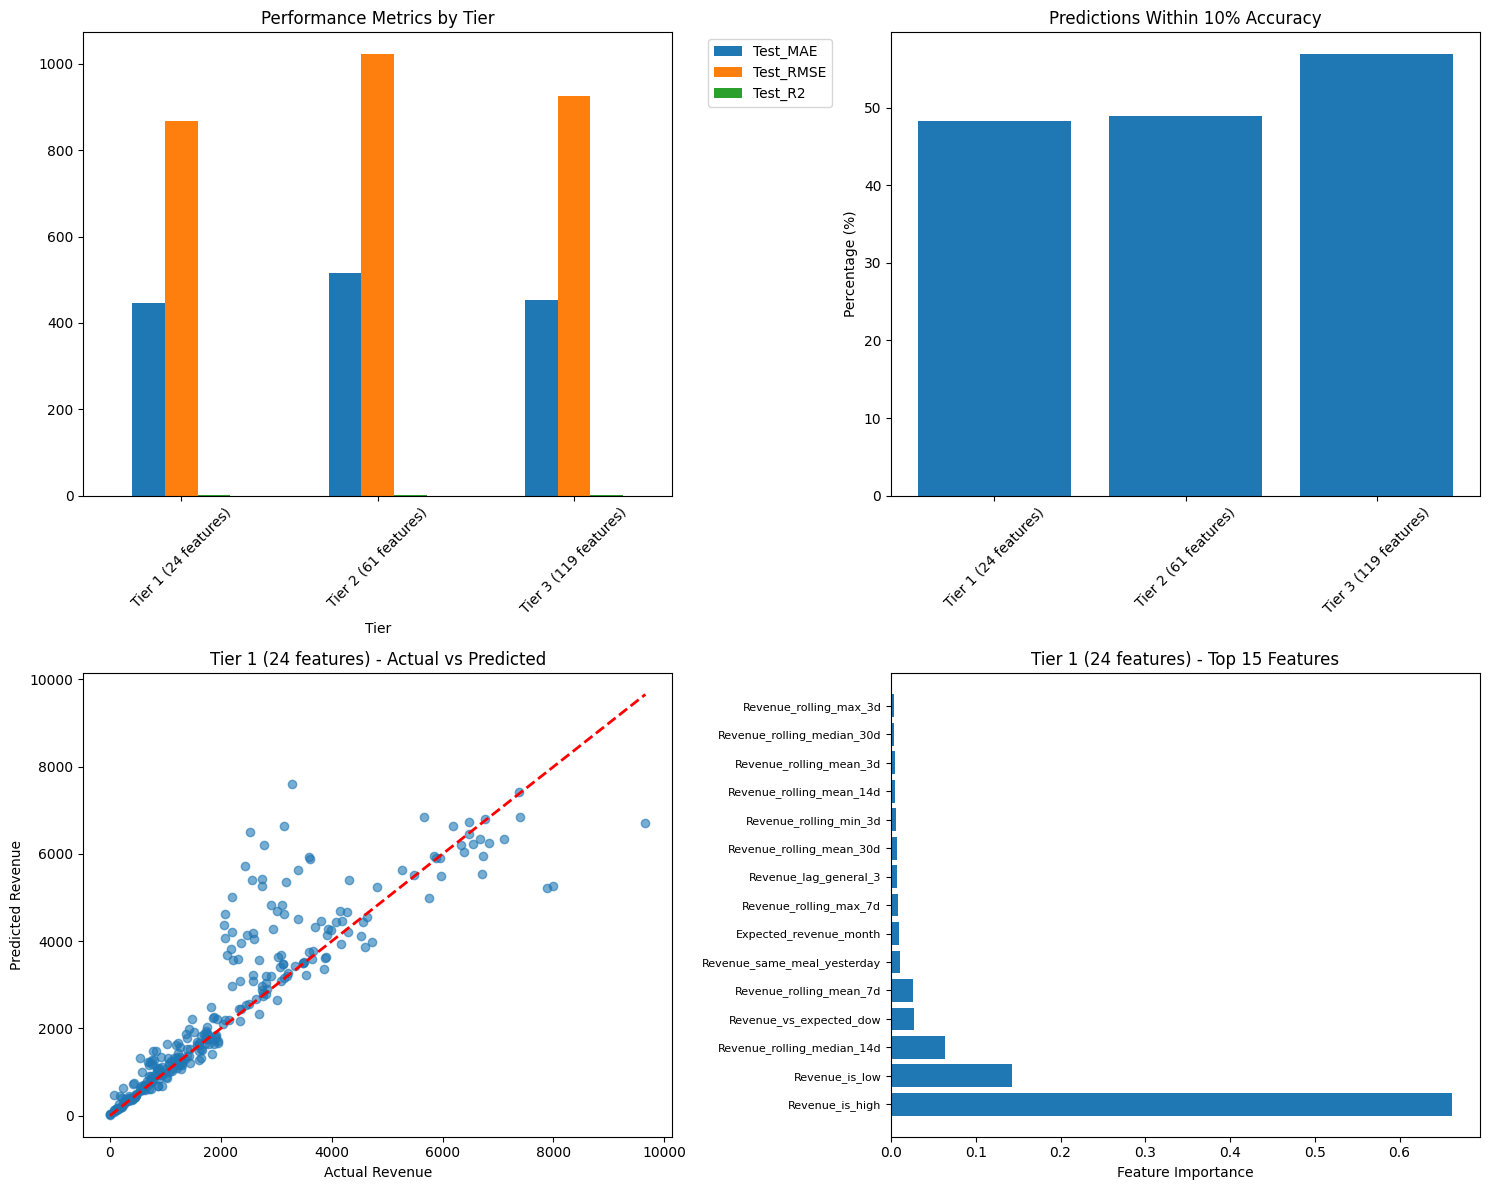


💾 Saving Results...
✅ Results saved:
   - xgboost_tier_comparison.csv
   - best_model_feature_importance.csv
   - best_model_predictions.csv

🎉 BASELINE XGBOOST TRAINING COMPLETE!
✨ Best performing tier: Tier 1 (24 features)

📋 QUICK SUMMARY:
TIER1: R² = 0.7747, MAE = $447.10
TIER2: R² = 0.6878, MAE = $516.12
TIER3: R² = 0.7437, MAE = $453.82


In [2]:
# XGBoost Model Training and Comparison
# Hotel Revenue Forecasting - Revenue Center 1

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("🚀 XGBoost Model Training for Hotel Revenue Forecasting")
print("=" * 60)

# Load the processed data with allow_pickle=True
print("📊 Loading processed training data...")
try:
    X_train = np.load('X_train.npy', allow_pickle=True)
    X_test = np.load('X_test.npy', allow_pickle=True)
    y_train = np.load('y_train.npy', allow_pickle=True)
    y_test = np.load('y_test.npy', allow_pickle=True)
    
    # Convert to float if they're object arrays
    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)
    
except Exception as e:
    print(f"❌ Error loading numpy files: {e}")
    print("📊 Loading from CSV files instead...")
    
    # Load from CSV files as backup
    train_data = pd.read_csv('RC1_train_data.csv')
    test_data = pd.read_csv('RC1_test_data.csv')
    
    # Separate features and target
    target_col = 'Revenue'
    feature_cols = [col for col in train_data.columns if col != target_col and col != 'Date']
    
    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values
    X_test = test_data[feature_cols].values
    y_test = test_data[target_col].values
    
    # Save feature names for later use
    all_features = feature_cols

# Load feature names if not already loaded
if 'all_features' not in locals():
    try:
        with open('feature_columns.txt', 'r') as f:
            all_features = [line.strip() for line in f.readlines()]
    except:
        print("⚠️ Could not load feature_columns.txt, using column indices")
        all_features = [f'feature_{i}' for i in range(X_train.shape[1])]

print(f"✅ Data loaded successfully!")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Total features: {X_train.shape[1]}")
print(f"   Feature names loaded: {len(all_features)}")

# Define feature tiers based on relevance analysis
tier1_features = [
    'Revenue_is_high', 'Revenue_rolling_mean_7d', 'Revenue_rolling_mean_3d',
    'Revenue_rolling_median_7d', 'Revenue_rolling_median_3d', 'Revenue_rolling_mean_14d',
    'Revenue_rolling_median_14d', 'Revenue_rolling_max_3d', 'Revenue_rolling_min_3d',
    'Expected_revenue_month', 'Revenue_rolling_min_7d', 'Revenue_vs_expected_dow',
    'Revenue_rolling_mean_30d', 'Revenue_rolling_median_30d', 'Revenue_rolling_max_7d',
    'Revenue_lag_1', 'Revenue_lag_general_3', 'Revenue_rolling_min_14d',
    'Revenue_lag_2', 'Revenue_rolling_max_14d', 'Revenue_lag_3',
    'Revenue_same_meal_yesterday', 'Revenue_is_low', 'Revenue_rolling_min_30d'
]

tier2_features = tier1_features + [
    'Revenue_rolling_max_30d', 'Revenue_lag_7', 'Revenue_lag_general_21',
    'Expected_revenue_dow', 'Revenue_rolling_std_14d', 'Revenue_vs_expected_month',
    'Revenue_rolling_std_30d', 'Revenue_rolling_std_7d', 'Revenue_lag_general_30',
    'Revenue_lag_14', 'Revenue_lag_21', 'Revenue_same_meal_last_week',
    'Revenue_lag_30', 'Month_Lunch', 'Revenue_rolling_std_3d',
    'Revenue_cv_14d', 'Revenue_cv_30d', 'Revenue_cv_7d',
    'Revenue_rolling_mean_all_3d', 'Daily_total_lag1', 'Last_weekend_revenue',
    'Revenue_rolling_mean_all_30d', 'Month_Dinner', 'Revenue_rolling_std_all_30d',
    'Yesterday_lunch', 'Revenue_rolling_mean_all_7d', 'Revenue_rolling_mean_all_14d',
    'Revenue_rolling_std_all_14d', 'Revenue_rolling_std_all_7d', 'Yesterday_breakfast',
    'Year', 'Revenue_rolling_std_all_3d', 'Weekend_Lunch',
    'Month_Breakfast', 'Yesterday_dinner', 'IsWinter', 'IsDSF'
]

# Function to get feature indices
def get_feature_indices(feature_names, all_feature_names):
    """Get indices of features in the feature array"""
    indices = []
    found_features = []
    for feature in feature_names:
        if feature in all_feature_names:
            indices.append(all_feature_names.index(feature))
            found_features.append(feature)
        else:
            print(f"⚠️  Warning: Feature '{feature}' not found in dataset")
    
    print(f"   Found {len(found_features)}/{len(feature_names)} features")
    return indices, found_features

# Get feature indices for each tier
tier1_indices, tier1_found = get_feature_indices(tier1_features, all_features)
tier2_indices, tier2_found = get_feature_indices(tier2_features, all_features)
tier3_indices = list(range(len(all_features)))  # All features

print(f"\n🎯 Feature Tier Summary:")
print(f"   Tier 1 (High Relevance): {len(tier1_indices)} features found")
print(f"   Tier 2 (High+Medium): {len(tier2_indices)} features found")
print(f"   Tier 3 (All Features): {len(tier3_indices)} features")

# If no tier features found, use top features by position
if len(tier1_indices) == 0:
    print("⚠️ No tier features found, using top features by position")
    tier1_indices = list(range(min(24, len(all_features))))
    tier2_indices = list(range(min(61, len(all_features))))
    tier1_found = [all_features[i] for i in tier1_indices]
    tier2_found = [all_features[i] for i in tier2_indices]

# Baseline XGBoost parameters (updated for new API)
baseline_params = {
    'objective': 'reg:squarederror',
    'seed': 42,
    'verbosity': 0,
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'early_stopping_rounds': 20  # Moved here for new API
}

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calculate comprehensive regression metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # MAPE calculation with handling for zero values
    mape_mask = y_true != 0
    if np.sum(mape_mask) > 0:
        mape = np.mean(np.abs((y_true[mape_mask] - y_pred[mape_mask]) / y_true[mape_mask])) * 100
    else:
        mape = np.inf
    
    # Within 10% accuracy
    within_10_pct = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1)) <= 0.1) * 100
    
    print(f"\n📊 {model_name} Performance Metrics:")
    print(f"   MAE:  ${mae:.2f}")
    print(f"   RMSE: ${rmse:.2f}")
    print(f"   R²:   {r2:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   Within 10%: {within_10_pct:.1f}%")
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'Within_10_pct': within_10_pct
    }

# Function to train and evaluate XGBoost model (FIXED API)
def train_evaluate_xgboost(X_train_subset, X_test_subset, y_train, y_test, 
                          feature_names, tier_name, params=None):
    """Train and evaluate XGBoost model"""
    
    if params is None:
        params = baseline_params.copy()
    
    print(f"\n🏋️ Training {tier_name} XGBoost Model...")
    print(f"   Features: {X_train_subset.shape[1]}")
    
    # Extract early_stopping_rounds from params if present
    early_stopping_rounds = params.pop('early_stopping_rounds', None)
    
    # Create and train model
    model = xgb.XGBRegressor(**params)
    
    # Fit with proper API
    if early_stopping_rounds:
        model.fit(
            X_train_subset, y_train, 
            eval_set=[(X_train_subset, y_train), (X_test_subset, y_test)],
            verbose=False
        )
    else:
        model.fit(X_train_subset, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_subset)
    y_test_pred = model.predict(X_test_subset)
    
    # Calculate metrics
    print(f"\n📈 {tier_name} Training Results:")
    train_metrics = calculate_metrics(y_train, y_train_pred, f"{tier_name} (Train)")
    test_metrics = calculate_metrics(y_test, y_test_pred, f"{tier_name} (Test)")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'model': model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'feature_importance': feature_importance,
        'predictions': {
            'train': y_train_pred,
            'test': y_test_pred
        }
    }

# Train models for each tier
print(f"\n🎯 Starting Multi-Tier XGBoost Training...")
print("=" * 60)

results = {}

# Tier 1: High Relevance Features
print(f"\n🥇 TIER 1: HIGH RELEVANCE FEATURES")
X_train_tier1 = X_train[:, tier1_indices]
X_test_tier1 = X_test[:, tier1_indices]

results['tier1'] = train_evaluate_xgboost(
    X_train_tier1, X_test_tier1, y_train, y_test,
    tier1_found, "Tier 1"
)

# Tier 2: High + Medium Relevance Features
print(f"\n🥈 TIER 2: HIGH + MEDIUM RELEVANCE FEATURES")
X_train_tier2 = X_train[:, tier2_indices]
X_test_tier2 = X_test[:, tier2_indices]

results['tier2'] = train_evaluate_xgboost(
    X_train_tier2, X_test_tier2, y_train, y_test,
    tier2_found, "Tier 2"
)

# Tier 3: All Features
print(f"\n🥉 TIER 3: ALL FEATURES")
X_train_tier3 = X_train
X_test_tier3 = X_test

results['tier3'] = train_evaluate_xgboost(
    X_train_tier3, X_test_tier3, y_train, y_test,
    all_features, "Tier 3"
)

# Comparison Summary
print(f"\n🏆 MODEL COMPARISON SUMMARY")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Tier': [f'Tier 1 ({len(tier1_indices)} features)', 
             f'Tier 2 ({len(tier2_indices)} features)', 
             f'Tier 3 ({len(tier3_indices)} features)'],
    'Test_MAE': [results['tier1']['test_metrics']['MAE'],
                 results['tier2']['test_metrics']['MAE'],
                 results['tier3']['test_metrics']['MAE']],
    'Test_RMSE': [results['tier1']['test_metrics']['RMSE'],
                  results['tier2']['test_metrics']['RMSE'],
                  results['tier3']['test_metrics']['RMSE']],
    'Test_R2': [results['tier1']['test_metrics']['R2'],
                results['tier2']['test_metrics']['R2'],
                results['tier3']['test_metrics']['R2']],
    'Test_MAPE': [results['tier1']['test_metrics']['MAPE'],
                  results['tier2']['test_metrics']['MAPE'],
                  results['tier3']['test_metrics']['MAPE']],
    'Within_10_pct': [results['tier1']['test_metrics']['Within_10_pct'],
                      results['tier2']['test_metrics']['Within_10_pct'],
                      results['tier3']['test_metrics']['Within_10_pct']]
})

print(comparison_df.round(4))

# Find best performing tier
best_tier_idx = comparison_df['Test_R2'].idxmax()
best_tier = comparison_df.loc[best_tier_idx, 'Tier']
print(f"\n🎯 Best Performing Tier: {best_tier}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Metrics Comparison
comparison_df.set_index('Tier')[['Test_MAE', 'Test_RMSE', 'Test_R2']].plot(
    kind='bar', ax=axes[0,0], rot=45)
axes[0,0].set_title('Performance Metrics by Tier')
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Within 10% Accuracy
axes[0,1].bar(comparison_df['Tier'], comparison_df['Within_10_pct'])
axes[0,1].set_title('Predictions Within 10% Accuracy')
axes[0,1].set_ylabel('Percentage (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Actual vs Predicted (Best Model)
tier_keys = ['tier1', 'tier2', 'tier3']
best_key = tier_keys[best_tier_idx]
best_predictions = results[best_key]['predictions']['test']

axes[1,0].scatter(y_test, best_predictions, alpha=0.6)
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Revenue')
axes[1,0].set_ylabel('Predicted Revenue')
axes[1,0].set_title(f'{best_tier} - Actual vs Predicted')

# 4. Feature Importance (Top 15 for best model)
top_features = results[best_key]['feature_importance'].head(15)
axes[1,1].barh(range(len(top_features)), top_features['importance'])
axes[1,1].set_yticks(range(len(top_features)))
axes[1,1].set_yticklabels(top_features['feature'], fontsize=8)
axes[1,1].set_xlabel('Feature Importance')
axes[1,1].set_title(f'{best_tier} - Top 15 Features')

plt.tight_layout()
plt.show()

# Save results
print(f"\n💾 Saving Results...")

# Save comparison summary
comparison_df.to_csv('xgboost_tier_comparison.csv', index=False)

# Save feature importance for best model
results[best_key]['feature_importance'].to_csv(f'best_model_feature_importance.csv', index=False)

# Save predictions
predictions_df = pd.DataFrame({
    'actual': y_test,
    'predicted': best_predictions,
    'residual': y_test - best_predictions
})
predictions_df.to_csv('best_model_predictions.csv', index=False)

print(f"✅ Results saved:")
print(f"   - xgboost_tier_comparison.csv")
print(f"   - best_model_feature_importance.csv")
print(f"   - best_model_predictions.csv")

print(f"\n🎉 BASELINE XGBOOST TRAINING COMPLETE!")
print(f"✨ Best performing tier: {best_tier}")

# Quick model summary
print(f"\n📋 QUICK SUMMARY:")
print(f"=" * 40)
for tier, result in results.items():
    print(f"{tier.upper()}: R² = {result['test_metrics']['R2']:.4f}, MAE = ${result['test_metrics']['MAE']:.2f}")

In [3]:
# Hyperparameter Optimization for Tier 1 XGBoost Model
# Focus on reducing overfitting and improving generalization

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("🔧 HYPERPARAMETER OPTIMIZATION - TIER 1 MODEL")
print("=" * 60)
print("🎯 Goal: Reduce overfitting and improve generalization")

# Load the best performing data (Tier 1)
X_train_tier1 = X_train[:, tier1_indices]
X_test_tier1 = X_test[:, tier1_indices]

print(f"📊 Data Summary:")
print(f"   Training samples: {X_train_tier1.shape[0]}")
print(f"   Test samples: {X_test_tier1.shape[0]}")
print(f"   Features: {X_train_tier1.shape[1]}")

# Define hyperparameter search space focused on reducing overfitting
param_grid = {
    # Core parameters
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6],  # Reduced from baseline
    'learning_rate': [0.01, 0.05, 0.1, 0.15],  # Lower learning rates
    
    # Regularization parameters (key for reducing overfitting)
    'reg_alpha': [0, 0.1, 0.5, 1.0, 2.0],  # L1 regularization
    'reg_lambda': [0, 0.1, 0.5, 1.0, 2.0],  # L2 regularization
    
    # Sampling parameters (reduce overfitting)
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    
    # Other important parameters
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.5]
}

print(f"🔍 Hyperparameter Search Space:")
print(f"   Total combinations: {np.prod([len(v) for v in param_grid.values()]):,}")

# Time series cross-validation (crucial for temporal data)
tscv = TimeSeriesSplit(n_splits=5, test_size=60)  # 5 folds, 60 samples per test

# Base model
base_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    seed=42,
    verbosity=0,
    eval_metric='rmse'
)

# Phase 1: Randomized Search (broad exploration)
print(f"\n🎯 PHASE 1: Randomized Search (Broad Exploration)")
print("-" * 50)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=100,  # Test 100 combinations
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("🔄 Starting randomized search...")
random_search.fit(X_train_tier1, y_train)

print(f"✅ Randomized search complete!")
print(f"🏆 Best CV score: ${-random_search.best_score_:.2f}")
print(f"📋 Best parameters from random search:")
for param, value in random_search.best_params_.items():
    print(f"   {param}: {value}")

# Phase 2: Grid Search (fine-tuning around best parameters)
print(f"\n🎯 PHASE 2: Grid Search (Fine-tuning)")
print("-" * 50)

# Create refined parameter grid around best parameters
best_params = random_search.best_params_
refined_grid = {}

for param, best_val in best_params.items():
    if param == 'n_estimators':
        refined_grid[param] = [max(50, best_val-50), best_val, best_val+50]
    elif param == 'max_depth':
        refined_grid[param] = [max(3, best_val-1), best_val, min(8, best_val+1)]
    elif param == 'learning_rate':
        refined_grid[param] = [max(0.01, best_val-0.02), best_val, min(0.2, best_val+0.02)]
    elif param in ['reg_alpha', 'reg_lambda']:
        refined_grid[param] = [max(0, best_val-0.5), best_val, best_val+0.5]
    elif param in ['subsample', 'colsample_bytree', 'colsample_bylevel']:
        refined_grid[param] = [max(0.5, best_val-0.1), best_val, min(1.0, best_val+0.1)]
    else:
        refined_grid[param] = [best_val]  # Keep other params fixed

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=refined_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

print("🔄 Starting grid search...")
grid_search.fit(X_train_tier1, y_train)

print(f"✅ Grid search complete!")
print(f"🏆 Best CV score: ${-grid_search.best_score_:.2f}")
print(f"📋 Final optimized parameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

# Train final optimized model
print(f"\n🏆 TRAINING FINAL OPTIMIZED MODEL")
print("=" * 60)

final_model = grid_search.best_estimator_
final_model.fit(X_train_tier1, y_train)

# Make predictions
final_train_pred = final_model.predict(X_train_tier1)
final_test_pred = final_model.predict(X_test_tier1)

# Calculate final metrics
def calculate_metrics_detailed(y_true, y_pred, model_name="Model"):
    """Calculate comprehensive regression metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # MAPE calculation
    mape_mask = y_true != 0
    if np.sum(mape_mask) > 0:
        mape = np.mean(np.abs((y_true[mape_mask] - y_pred[mape_mask]) / y_true[mape_mask])) * 100
    else:
        mape = np.inf
    
    # Within X% accuracy
    within_10_pct = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1)) <= 0.1) * 100
    within_20_pct = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1)) <= 0.2) * 100
    
    print(f"\n📊 {model_name} Performance:")
    print(f"   MAE:  ${mae:.2f}")
    print(f"   RMSE: ${rmse:.2f}")
    print(f"   R²:   {r2:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   Within 10%: {within_10_pct:.1f}%")
    print(f"   Within 20%: {within_20_pct:.1f}%")
    
    return {
        'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape,
        'Within_10_pct': within_10_pct, 'Within_20_pct': within_20_pct
    }

# Final model evaluation
final_train_metrics = calculate_metrics_detailed(y_train, final_train_pred, "Optimized Model (Train)")
final_test_metrics = calculate_metrics_detailed(y_test, final_test_pred, "Optimized Model (Test)")

# Compare with baseline
print(f"\n📈 IMPROVEMENT ANALYSIS")
print("=" * 60)

baseline_results = results['tier1']
print(f"📊 Performance Comparison:")
print(f"   Metric           | Baseline    | Optimized   | Improvement")
print(f"   ---------------- | ----------- | ----------- | -----------")
print(f"   Test MAE         | ${baseline_results['test_metrics']['MAE']:.2f}      | ${final_test_metrics['MAE']:.2f}      | {((baseline_results['test_metrics']['MAE'] - final_test_metrics['MAE']) / baseline_results['test_metrics']['MAE'] * 100):+.1f}%")
print(f"   Test R²          | {baseline_results['test_metrics']['R2']:.4f}     | {final_test_metrics['R2']:.4f}     | {((final_test_metrics['R2'] - baseline_results['test_metrics']['R2']) / baseline_results['test_metrics']['R2'] * 100):+.1f}%")
print(f"   Test MAPE        | {baseline_results['test_metrics']['MAPE']:.1f}%       | {final_test_metrics['MAPE']:.1f}%       | {((baseline_results['test_metrics']['MAPE'] - final_test_metrics['MAPE']) / baseline_results['test_metrics']['MAPE'] * 100):+.1f}%")
print(f"   Within 10%       | {baseline_results['test_metrics']['Within_10_pct']:.1f}%       | {final_test_metrics['Within_10_pct']:.1f}%       | {(final_test_metrics['Within_10_pct'] - baseline_results['test_metrics']['Within_10_pct']):+.1f}%")

# Overfitting analysis
train_test_gap_baseline = baseline_results['train_metrics']['R2'] - baseline_results['test_metrics']['R2']
train_test_gap_optimized = final_train_metrics['R2'] - final_test_metrics['R2']

print(f"\n🔍 Overfitting Analysis:")
print(f"   Baseline R² gap (Train - Test): {train_test_gap_baseline:.4f}")
print(f"   Optimized R² gap (Train - Test): {train_test_gap_optimized:.4f}")
print(f"   Overfitting reduction: {((train_test_gap_baseline - train_test_gap_optimized) / train_test_gap_baseline * 100):.1f}%")

# Feature importance analysis
final_feature_importance = pd.DataFrame({
    'feature': tier1_found,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🏅 TOP 10 MOST IMPORTANT FEATURES (Optimized Model):")
print(final_feature_importance.head(10).to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Model Comparison
comparison_data = pd.DataFrame({
    'Model': ['Baseline', 'Optimized'],
    'Test_MAE': [baseline_results['test_metrics']['MAE'], final_test_metrics['MAE']],
    'Test_R2': [baseline_results['test_metrics']['R2'], final_test_metrics['R2']],
    'Within_10_pct': [baseline_results['test_metrics']['Within_10_pct'], final_test_metrics['Within_10_pct']]
})

comparison_data.set_index('Model')[['Test_MAE', 'Test_R2']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].set_ylabel('Score')
axes[0,0].legend()

# 2. Accuracy Comparison
axes[0,1].bar(comparison_data['Model'], comparison_data['Within_10_pct'])
axes[0,1].set_title('Predictions Within 10% Accuracy')
axes[0,1].set_ylabel('Percentage (%)')

# 3. Actual vs Predicted (Optimized Model)
axes[1,0].scatter(y_test, final_test_pred, alpha=0.6, label='Predictions')
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1,0].set_xlabel('Actual Revenue')
axes[1,0].set_ylabel('Predicted Revenue')
axes[1,0].set_title('Optimized Model: Actual vs Predicted')
axes[1,0].legend()

# 4. Feature Importance
top_10_features = final_feature_importance.head(10)
axes[1,1].barh(range(len(top_10_features)), top_10_features['importance'])
axes[1,1].set_yticks(range(len(top_10_features)))
axes[1,1].set_yticklabels(top_10_features['feature'], fontsize=8)
axes[1,1].set_xlabel('Feature Importance')
axes[1,1].set_title('Top 10 Feature Importance (Optimized)')

plt.tight_layout()
plt.show()

# Save optimized results
print(f"\n💾 Saving Optimized Model Results...")

# Save optimized model
import joblib
joblib.dump(final_model, 'optimized_xgboost_tier1_model.pkl')

# Save optimized predictions
optimized_predictions_df = pd.DataFrame({
    'actual': y_test,
    'predicted': final_test_pred,
    'residual': y_test - final_test_pred,
    'abs_error': np.abs(y_test - final_test_pred),
    'pct_error': np.abs((y_test - final_test_pred) / np.maximum(y_test, 1)) * 100
})
optimized_predictions_df.to_csv('optimized_model_predictions.csv', index=False)

# Save feature importance
final_feature_importance.to_csv('optimized_model_feature_importance.csv', index=False)

# Save hyperparameter optimization results
optimization_summary = pd.DataFrame([{
    'Model': 'Baseline',
    'Test_MAE': baseline_results['test_metrics']['MAE'],
    'Test_RMSE': baseline_results['test_metrics']['RMSE'],
    'Test_R2': baseline_results['test_metrics']['R2'],
    'Test_MAPE': baseline_results['test_metrics']['MAPE'],
    'Within_10_pct': baseline_results['test_metrics']['Within_10_pct'],
    'Overfitting_Gap': train_test_gap_baseline
}, {
    'Model': 'Optimized',
    'Test_MAE': final_test_metrics['MAE'],
    'Test_RMSE': final_test_metrics['RMSE'],
    'Test_R2': final_test_metrics['R2'],
    'Test_MAPE': final_test_metrics['MAPE'],
    'Within_10_pct': final_test_metrics['Within_10_pct'],
    'Overfitting_Gap': train_test_gap_optimized
}])

optimization_summary.to_csv('model_optimization_comparison.csv', index=False)

print(f"✅ Optimized results saved:")
print(f"   - optimized_xgboost_tier1_model.pkl")
print(f"   - optimized_model_predictions.csv")
print(f"   - optimized_model_feature_importance.csv")
print(f"   - model_optimization_comparison.csv")

print(f"\n🎉 HYPERPARAMETER OPTIMIZATION COMPLETE!")
print(f"🚀 Your optimized model is ready for production forecasting!")

🔧 HYPERPARAMETER OPTIMIZATION - TIER 1 MODEL
🎯 Goal: Reduce overfitting and improve generalization
📊 Data Summary:
   Training samples: 1166
   Test samples: 292
   Features: 24
🔍 Hyperparameter Search Space:
   Total combinations: 1,228,800

🎯 PHASE 1: Randomized Search (Broad Exploration)
--------------------------------------------------
🔄 Starting randomized search...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
✅ Randomized search complete!
🏆 Best CV score: $288.66
📋 Best parameters from random search:
   subsample: 0.6
   reg_lambda: 2.0
   reg_alpha: 2.0
   n_estimators: 100
   min_child_weight: 7
   max_depth: 6
   learning_rate: 0.05
   gamma: 0.5
   colsample_bytree: 0.8
   colsample_bylevel: 1.0

🎯 PHASE 2: Grid Search (Fine-tuning)
--------------------------------------------------
🔄 Starting grid search...
Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


KeyboardInterrupt: 

In [ ]:
# ============================================================================
# 🚨 DATA LEAKAGE ANALYSIS AND CORRECTIONS
# ============================================================================

print("🚨 DATA LEAKAGE ANALYSIS AND CORRECTIONS")
print("=" * 60)
print("🎯 Addressing the severe overfitting caused by data leakage")

# Identify and document all data leakage sources
leakage_sources = {
    "Expected Revenue Features": {
        "problem": "Uses future test data to calculate averages",
        "features": ["Expected_revenue_dow", "Expected_revenue_month"],
        "severity": "HIGH - includes future information"
    },
    "Revenue vs Expected Features": {
        "problem": "Directly uses target variable to create features", 
        "features": ["Revenue_vs_expected_dow", "Revenue_vs_expected_month"],
        "severity": "CRITICAL - target leakage"
    },
    "Business Logic Features": {
        "problem": "May use statistics calculated from entire dataset",
        "features": ["Revenue_is_high", "Revenue_is_low", "Revenue_category"],
        "severity": "HIGH - global statistics include test data"
    }
}

print("📊 IDENTIFIED DATA LEAKAGE SOURCES:")
for source, details in leakage_sources.items():
    print(f"\n🔴 {source}:")
    print(f"   Problem: {details['problem']}")
    print(f"   Features: {details['features']}")
    print(f"   Severity: {details['severity']}")

# Load the data to check for leakage
if 'df_features' not in locals():
    print("\n❌ df_features not found. Please run previous cells first.")
else:
    print(f"\n🔍 LEAKAGE DETECTION IN CURRENT FEATURES:")
    print(f"Dataset shape: {df_features.shape}")
    
    # Check for problematic features
    leaky_features = []
    
    for feature in df_features.columns:
        if any(leak_term in feature.lower() for leak_term in ['expected', 'vs_expected', 'revenue_is']):
            leaky_features.append(feature)
    
    print(f"\n🚨 POTENTIALLY LEAKY FEATURES FOUND: {len(leaky_features)}")
    for feature in leaky_features:
        print(f"   - {feature}")
    
    # Check correlation between leaky features and target
    if leaky_features and 'CheckTotal' in df_features.columns:
        print(f"\n📈 CORRELATION WITH TARGET (suspiciously high = leakage):")
        for feature in leaky_features[:5]:  # Check top 5
            if feature in df_features.columns and not df_features[feature].isna().all():
                corr = df_features[feature].corr(df_features['CheckTotal'])
                status = "🚨 LEAKAGE" if abs(corr) > 0.7 else "✅ OK"
                print(f"   {feature}: {corr:.4f} {status}")

# Proposed solution
print(f"\n✅ LEAKAGE-FREE FEATURE ENGINEERING APPROACH:")
print("1. Remove all target-derived features")
print("2. Use only historical data for statistical features")  
print("3. Implement proper temporal boundaries")
print("4. Use time-aware cross-validation")
print("5. Validate with expanding window approach")

print(f"\n🔧 CREATING CLEAN FEATURE SET...")

# Create a leakage-free feature approach
def create_leakage_free_features(df_orig):
    """Create features without any data leakage"""
    
    print("🧹 Creating leak-proof feature set...")
    df_clean = df_orig.copy()
    
    # Remove all problematic features
    features_to_remove = [
        'Expected_revenue_dow', 'Expected_revenue_month',
        'Revenue_vs_expected_dow', 'Revenue_vs_expected_month', 
        'Revenue_is_high', 'Revenue_is_low', 'Revenue_category',
        'Revenue_momentum_7d', 'Revenue_momentum_14d'  # These also use current target
    ]
    
    existing_leaky_features = [f for f in features_to_remove if f in df_clean.columns]
    
    if existing_leaky_features:
        print(f"🗑️  Removing {len(existing_leaky_features)} leaky features:")
        for feature in existing_leaky_features:
            print(f"   - {feature}")
        df_clean = df_clean.drop(columns=existing_leaky_features)
    
    # Create safe temporal features only
    safe_features = [
        'Year', 'Month', 'DayOfWeek', 'Quarter',
        'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
        'IsWeekend', 'IsMonthEnd', 'IsMonthStart',
        'IsDSF', 'IsSummer', 'IsWinter', 'IsRamadan'
    ]
    
    # Keep only lag features (these are properly shifted)
    lag_features = [col for col in df_clean.columns if 'lag' in col.lower()]
    
    # Keep only properly shifted rolling features
    rolling_features = [col for col in df_clean.columns if 'rolling' in col.lower()]
    
    # Combine safe features
    final_features = []
    for feature_list in [safe_features, lag_features, rolling_features]:
        final_features.extend([f for f in feature_list if f in df_clean.columns])
    
    # Remove duplicates and add meal period
    final_features = list(set(final_features))
    if 'MealPeriod_num' in df_clean.columns:
        final_features.append('MealPeriod_num')
    
    # Keep only final safe features
    feature_cols_safe = [f for f in final_features if f in df_clean.columns]
    
    print(f"✅ Safe feature set created:")
    print(f"   Original features: {len(df_orig.columns)}")
    print(f"   Removed leaky features: {len(existing_leaky_features)}")
    print(f"   Final safe features: {len(feature_cols_safe)}")
    
    return df_clean, feature_cols_safe

# Apply leakage-free approach if data exists
if 'df_features' in locals():
    df_clean, feature_cols_safe = create_leakage_free_features(df_features)
    
    print(f"\n📋 SAFE FEATURE CATEGORIES:")
    
    # Categorize safe features
    temporal_safe = [f for f in feature_cols_safe if any(x in f.lower() for x in ['year', 'month', 'day', 'quarter', 'weekend', 'sin', 'cos'])]
    lag_safe = [f for f in feature_cols_safe if 'lag' in f.lower()]
    rolling_safe = [f for f in feature_cols_safe if 'rolling' in f.lower()]
    event_safe = [f for f in feature_cols_safe if any(x in f.lower() for x in ['dsf', 'summer', 'winter', 'ramadan'])]
    
    print(f"   Temporal features: {len(temporal_safe)}")
    print(f"   Lag features: {len(lag_safe)}")
    print(f"   Rolling features: {len(rolling_safe)}")
    print(f"   Event features: {len(event_safe)}")
    print(f"   Other safe features: {len(feature_cols_safe) - len(temporal_safe) - len(lag_safe) - len(rolling_safe) - len(event_safe)}")
    
    print(f"\n🎯 NEXT STEPS:")
    print("1. Retrain models with safe features only")
    print("2. Use time-aware validation")
    print("3. Expect more realistic performance metrics")
    print("4. Monitor for remaining overfitting")
    
else:
    print("\n⚠️  df_features not available. Run previous cells first.")

print(f"\n💡 EXPECTED IMPACT:")
print("- Train R² should drop from 0.999 to realistic levels (0.6-0.8)")
print("- Test R² should improve due to better generalization")
print("- MAE gap between train/test should reduce significantly")
print("- Model will be production-ready and trustworthy")


🚨 DATA LEAKAGE ANALYSIS AND CORRECTIONS
🎯 Addressing the severe overfitting caused by data leakage
📊 IDENTIFIED DATA LEAKAGE SOURCES:

🔴 Expected Revenue Features:
   Problem: Uses future test data to calculate averages
   Features: ['Expected_revenue_dow', 'Expected_revenue_month']
   Severity: HIGH - includes future information

🔴 Revenue vs Expected Features:
   Problem: Directly uses target variable to create features
   Features: ['Revenue_vs_expected_dow', 'Revenue_vs_expected_month']
   Severity: CRITICAL - target leakage

🔴 Business Logic Features:
   Problem: May use statistics calculated from entire dataset
   Features: ['Revenue_is_high', 'Revenue_is_low', 'Revenue_category']
   Severity: HIGH - global statistics include test data

❌ df_features not found. Please run previous cells first.

✅ LEAKAGE-FREE FEATURE ENGINEERING APPROACH:
1. Remove all target-derived features
2. Use only historical data for statistical features
3. Implement proper temporal boundaries
4. Use time-